- [Modelling](#Modelling)
  - [Import Libraries](#Import-Libraries)
  - [Read in Data](#Read-in-Data)
  - [Create Transition Status Variable](#Create-Transition-Status-Variable)
  - [Clean Rest of Data](#Clean-Rest-of-Data)
    - [Redefine Cleaning Data Function](#Redefine-Cleaning-Data-Function)
    - [Manually Cleaning Data](#Manually-Cleaning-Data)
    - [Cross-Validation](#Cross-Validation)
  - [Decision Trees](#Decision-Trees)
    - [SMOTE Technique](#SMOTE-Technique)
    - [Oversampling](#Oversampling)
    - [Undersampling](#Undersampling)
  - [XGBoost](#XGBoost)
    - [Grid Search](#Grid-Search)
    - [Train and Test Predictions](#Train-and-Test-Predictions)
    - [Top Predictors](#Top-Predictors)
  - [XGBoost Remodelled](#XGBoost-Remodelled)
    - [Prepare Data for Grid Search](#Prepare-Data-for-Grid-Search)
      - [Copy Dataset](#Copy-Dataset)
      - [Recreate Transition Status Variable](#Recreate-Transition-Status-Variable)
    - [Grid Search](#Grid-Search)
    - [Train and Test Datasets](#Train-and-Test-Datasets)
    - [Top Predictors](#Top-Predictors)
  - [XGBoost New Threshold](#XGBoost-New-Threshold)
    - [Data Cleaning](#Data-Cleaning)
      - [Recreate the Transition Variable](#Recreate-the-Transition-Variable)
      - [Finish Cleaning Data](#Finish-Cleaning-Data)
    - [Setup Cross Validation](#Setup-Cross-Validation)
    - [Grid Search](#Grid-Search)
    - [Train and Test Datasets](#Train-and-Test-Datasets)
    - [Top Predictors](#Top-Predictors)
  - [Logistic Regression ](#Logistic-Regression-)
    - [New Threshold](#New-Threshold)
      - [Cleaning Data](#Cleaning-Data)
      - [Grid Search](#Grid-Search)
      - [Model Coefficients](#Model-Coefficients)
      - [Multi-Colinearity](#Multi-Colinearity)
        - [Numeric Coefficients](#Numeric-Coefficients)
    - [Customer Segmentation](#Customer-Segmentation)
      - [Test Dataset Predictions](#Test-Dataset-Predictions)
      - [Entire Dataset Predictions](#Entire-Dataset-Predictions)
    - [Multiple Classes](#Multiple-Classes)
      - [Dataset Proportions](#Dataset-Proportions)
      - [Grid Search](#Grid-Search)
      - [ROC-AUC Score Single Class (UP)](#ROC-AUC-Score-Single-Class-(UP))

# Modelling

This notebook will explore my portion of the modelling process for Swire Coca Cola. My primary objective was to answer the question: 

* What customer characteristics enable a customer to transition from "Below the Threshold" in 2023 to "Above the Threshold" in 2024?

* Can customers be segmented into different groups based on their probability of transitoning? For instance:
    * 25% chance of transitioning - Low
    * 55% chance of transitioning - Medium
    * 75% chance of transitioning - High
    * 95% chance of transitioning - Very High

## Import Libraries

In [9]:
# Import necessary libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, roc_auc_score,make_scorer
from imblearn.over_sampling import SMOTE
from collections import Counter
from sklearn.model_selection import train_test_split
from sklearn.utils import resample
import xgboost as xgb
from xgboost import XGBClassifier
from imblearn.pipeline import Pipeline as ImbPipeline

## Read in Data

In [10]:
# Read in the dataframe and name it as sccu
sccu = pd.read_csv(r"C:\Users\varun\Box Sync\Business Analytics Degree\Semesters\Spring Semester 2025\IS 6813\Modelling\sccu_data.csv")

In [11]:
sccu.shape

(30755, 37)

There are 30,755 rows and 37 columns in this dataset.

In [12]:
sccu.head()

,Unnamed: 0,CUSTOMER_NUMBER,FIRST_TRANSACTION_DATE,LAST_TRANSACTION_DATE,TRANS_DAYS,TRANS_COUNT,TRANS_COUNT_2023,TRANS_COUNT_2024,ANNUAL_VOLUME_CASES_2023,ANNUAL_VOLUME_GALLON_2023,...,LOCAL_MARKET_PARTNER,CO2_CUSTOMER,ZIP_CODE,STATE_SHORT,DELIVERY_COST_2023_CASES,DELIVERY_COST_2024_CASES,DELIVERY_COST_2023_GALLON,DELIVERY_COST_2024_GALLON,DELIVERY_COST_2023,DELIVERY_COST_2024
0,1,500245678,2023-01-09,2024-11-20,682,44,27,17,210.0,160.0,...,True,True,66508,KS,938.785885,675.031755,428.063964,622.030448,1366.849849,1297.062203
1,2,500245685,2023-01-06,2024-08-16,589,63,46,17,24.0,577.5,...,True,True,21913,MD,206.051579,317.662851,1163.368809,1126.805640,1369.420388,1444.468491
2,3,500245686,2023-03-07,2024-12-17,652,9,5,4,17.5,0.0,...,True,False,1350,MA,128.200325,135.526058,0.000000,0.000000,128.200325,135.526058
3,4,500245687,2023-02-06,2024-10-28,631,18,9,9,0.0,125.0,...,True,True,42252,KY,0.000000,0.000000,470.060235,554.671077,470.060235,554.671077
4,5,500245689,2023-01-13,2024-12-26,714,85,40,45,124.0,422.5,...,True,False,42031,KY,1064.599825,1155.223773,1069.832321,921.629836,2134.432146,2076.853608


The above dataframe just shows the first 5 rows of the dataset. This has been done to show us a glimpse of the data frame's appearance. This dataset contains 37 columns, however there are a few columns that are critical:

* `THRESHOLD_2023`
* `THRESHOLD-2024`

These columns are going to be utilized to create the target variable which will be called `Transition_Status`. `Transition Status` will be described in more detail down below.

## Create Transition Status Variable

In [13]:
# Create copy of of sccu dataset
# It's important to to keep the original dataset intact, in case we want to do something else later on
sccu_segmentation = sccu.copy()

# Define conditions
conditions = [
    (sccu_segmentation['THRESHOLD_2023'] == "below") & (sccu_segmentation['THRESHOLD_2024'] == "above"),
    (sccu_segmentation['THRESHOLD_2023'] == "above") & (sccu_segmentation['THRESHOLD_2024'] == "below"),
    (sccu_segmentation['THRESHOLD_2023'] == "above") & (sccu_segmentation['THRESHOLD_2024'] == "above"),
    (sccu_segmentation['THRESHOLD_2023'] == "below") & (sccu_segmentation['THRESHOLD_2024'] == "below")
]

# Define corresponding labels
labels = ["Up", "Down", "Stays above Threshold", "Stays below Threshold"]

# Apply conditions to create the new column
sccu_segmentation['Transition_Status'] = np.select(conditions, labels, default="Unknown")

# Recode this column with numeric values for machine-learning purposes
sccu_segmentation['Transition_Status'] = sccu_segmentation['Transition_Status'].map({
    'Up': 1, 
    'Down': 0, 
    'Stays above Threshold': 0, 
    'Stays below Threshold': 0
})

# Check that Transition Status is in the sccu_segmentation dataset
print('Transition_Status' in sccu_segmentation.columns)



True


`Transition Status` shall be the main target variable for all the models. Transition Status basically models customers who were below the Threshold in 2023 and then moved to above the threshold in 2024. This scenario will be labelled as __Up__. There are however 3 other scenarios however that also must be considered:

* __Down__: Moving from above the Threshold in 2023 to below the Threshold in 2024.
* __Stays above Threshold__: Remaining above the Threshold in both 2023 and 2024.
* __Stays below Threshold__: Reamining below the Threshold in both 2023 and 2024.

Although, these 3 scenarios can provide insights, the objective is to mainly model customers who transistion from below to above the threshold. Thus, the __Up__ scenario will be coded as 1 while the other scenarios will be coded as zero. Consequently, this will force any model to view `Transition_Status` as a binary variable with __Up__ being the response level to be modelled.

In [14]:
def transition_status(df, v1, v2, v3, v4, new_col_name_2023=None, new_col_name_2024=None, 
                      new_threshold=None, old_colname_2023=None, old_colname_2024=None):
    """
    df = dataframe, v1 (Value 1) = Up, v2 (value 2) = Down, v3 (Value 3) = Stays above Threshold
    v4 (Value 4) = Stays below Threshold
    
    The below columns have been set to None by default are only if you want to change the threshold.
    new_col_name_2023 = None,
    new_col_name_2024=None, new_threshold = None,
    old_colname_2023 = None, 
    old_colname_2024 = None
    """
    # If else with if block for creating new columns while else is for just creating a transition status variable with existing threshold.
    if new_col_name_2023 and new_col_name_2024 and new_threshold is not None:
        # Create new column to test new threshold
        df[new_col_name_2023] = df[old_colname_2023] < new_threshold
        df[new_col_name_2024] = df[old_colname_2024] < new_threshold

        # Ensure the new columns exist in the dataframe before proceeding
        if new_col_name_2023 not in df.columns or new_col_name_2024 not in df.columns:
            raise ValueError(f"Columns {new_col_name_2023} or {new_col_name_2024} not created.")

        # Recreate the transition variable
        # Define conditions
        # below = True and above = False
        conditions = [
            (df[new_col_name_2023] == True) & (df[new_col_name_2024] == False),
            (df[new_col_name_2023] == False) & (df[new_col_name_2024] == True),
            (df[new_col_name_2023] == False) & (df[new_col_name_2024] == False),
            (df[new_col_name_2023] == True) & (df[new_col_name_2024] == True)
        ]

        # Define corresponding labels
        labels = ["Up", "Down", "Stays above Threshold", "Stays below Threshold"]

        # Apply conditions to create the new column
        df['Transition_Status'] = np.select(conditions, labels, default="Unknown")

        # Recode this column with numeric values for machine-learning purposes
        df['Transition_Status'] = df['Transition_Status'].map({
            'Up': v1, 
            'Down': v2, 
            'Stays above Threshold': v3, 
            'Stays below Threshold': v4
        })

        # Check that Transition Status is in the dataset
        print('Transition_Status' in df.columns)
        print("New Threshold Sucessfully Created")

        # Return the dataframe
        return df
        
    else:
        # Define the default cases (without new threshold columns)
        scenarios = [
            (df['THRESHOLD_2023'] == "below") & (df['THRESHOLD_2024'] == "above"),
            (df['THRESHOLD_2023'] == "above") & (df['THRESHOLD_2024'] == "below"),
            (df['THRESHOLD_2023'] == "above") & (df['THRESHOLD_2024'] == "above"),
            (df['THRESHOLD_2023'] == "below") & (df['THRESHOLD_2024'] == "below")
        ]

        # Define corresponding labels
        scenario_labels = ["Up", "Down", "Stays above Threshold", "Stays below Threshold"]

        # Apply conditions to create the new column
        df['Transition_Status'] = np.select(scenarios, scenario_labels, default="Unknown")

        # Recode this column with numeric values for machine-learning purposes
        df['Transition_Status'] = df['Transition_Status'].map({
            'Up': v1, 
            'Down': v2, 
            'Stays above Threshold': v3, 
            'Stays below Threshold': v4
        })

        # Check that Transition Status is in the dataset
        print('Transition_Status' in df.columns)

        # Return the dataframe
        return df


There may be a need to recreate the transition_status variable so the function transition_status has been created to make this process easier. Added in some additional functionality like creating a new threshold.

In [15]:
sccu_segmentation.head()

,Unnamed: 0,CUSTOMER_NUMBER,FIRST_TRANSACTION_DATE,LAST_TRANSACTION_DATE,TRANS_DAYS,TRANS_COUNT,TRANS_COUNT_2023,TRANS_COUNT_2024,ANNUAL_VOLUME_CASES_2023,ANNUAL_VOLUME_GALLON_2023,...,CO2_CUSTOMER,ZIP_CODE,STATE_SHORT,DELIVERY_COST_2023_CASES,DELIVERY_COST_2024_CASES,DELIVERY_COST_2023_GALLON,DELIVERY_COST_2024_GALLON,DELIVERY_COST_2023,DELIVERY_COST_2024,Transition_Status
0,1,500245678,2023-01-09,2024-11-20,682,44,27,17,210.0,160.0,...,True,66508,KS,938.785885,675.031755,428.063964,622.030448,1366.849849,1297.062203,0
1,2,500245685,2023-01-06,2024-08-16,589,63,46,17,24.0,577.5,...,True,21913,MD,206.051579,317.662851,1163.368809,1126.805640,1369.420388,1444.468491,0
2,3,500245686,2023-03-07,2024-12-17,652,9,5,4,17.5,0.0,...,False,1350,MA,128.200325,135.526058,0.000000,0.000000,128.200325,135.526058,0
3,4,500245687,2023-02-06,2024-10-28,631,18,9,9,0.0,125.0,...,True,42252,KY,0.000000,0.000000,470.060235,554.671077,470.060235,554.671077,0
4,5,500245689,2023-01-13,2024-12-26,714,85,40,45,124.0,422.5,...,False,42031,KY,1064.599825,1155.223773,1069.832321,921.629836,2134.432146,2076.853608,0


## Clean Rest of Data

In [16]:
# Create function to reuse the code later
def cleaning_data(dataset):
    # Drop these columns from the dataset. Threshold_2024 and other 2024 related variables are "future variable" and the other variables will not help with prediction
    transformed_df = dataset.drop(columns=['FIRST_TRANSACTION_DATE', 'LAST_TRANSACTION_DATE',"FIRST_DELIVERY_DATE","ON_BOARDING_DATE","Unnamed: 0","CUSTOMER_NUMBER", "PRIMARY_GROUP_NUMBER","ZIP_CODE",
                                 'TRANS_DAYS',"TRANS_COUNT_2024","ANNUAL_VOLUME_CASES_2024","ANNUAL_VOLUME_GALLON_2024",'ANNUAL_VOLUME_2024', 'TRANS_COUNT',
                                 'AVG_ORDER_VOLUME_2024','CHANGED_VOLUME','PERCENT_CHANGE',"THRESHOLD_2024","DELIVERY_COST_2024_GALLON",
                                 "DELIVERY_COST_2024","DELIVERY_COST_2024_CASES"])

    # Create list with following variables to one hot encode
    categorical_cols = ['THRESHOLD_2023', 'FREQUENT_ORDER_TYPE','COLD_DRINK_CHANNEL','TRADE_CHANNEL','SUB_TRADE_CHANNEL', 'STATE_SHORT']

    # Convert variables to one hot encoded dummy variables and assign back to transformed df.
    transformed_df = pd.get_dummies(transformed_df, columns=categorical_cols, drop_first=True)

    # Return the Dataset
    return transformed_df


The above code is creating a function that will drop several columns and then one-hot encode remaining categorical variables for model training purposes. There are however 2 reasons why some columns are being dropped: 

* __Future Variables__: Any variables related to 2024 or utilized 2024 data when being calculated.
    
    * For instance, `CHANGED_VOLUME`, `PERCENT_CHANGE` and `TRANS_DAYS` utilized 2024 data when being calculated. `CHANGED_VOLUME` represents the change in overall volume for a customer between 2023 and 2024. `PERCENT_CHANGE` also reflects this information, but as a percent. `TRANS_DAYS` is the total number of orders by a customer in 2023 and 2024. 
    
    * 2024 related variables are problematic since any model can directly map 2024 columns to whether a customer can move __UP__ in the `Transition_Status` variable. Especially if the `TRESHOLD_2024` variable is utilized which allows the model to directly model customers transitioning because it can compare `THRESHOLD_2023` values to `THRESHOLD_2024` values.
    
    * Moreover, Swire Coca Cola has provided 2 years of data which means that the data must be separated into past and future data which would be 2023 (past) and 2024 (future). Hence, any model should be trained on past data (2023) to predict future data (2024). 
        
        * Additionally in a real scenario, Swire Coca Cola would __not have access__ to data that occurs in the future. i.e 2028 data Thus, since there are only 2 years of data, 2023 data should be used for model training.


* **Miscellaneous Variables**: These are other variables that should be dropped because they do not contain valuable information:
    
    * `FIRST_TRANSACTION_DATE`: When a customer first ordered which is not going to reveal any insights about transitioning from below to above the threshold.
    
    * `LAST_TRANSACTION_DATE`: When a customer first ordered which is not going to reveal any insights about transitioning from below to above the threshold.
    
    * `FIRST_DELIVERY_DATE`: When Swire first delivered an order which is not going to reveal any insights about transitioning from below to above the threshold.
    
    * `ON_BOARDING_DATE`: When a customer first was entered into the system which is not going to reveal any insights about transitioning from below to above the threshold.
    
    * `Unnamed - 0`: Row number label, labels every row from 0 to 30,755. This is just a label and will offer any insights about transitioning.
    
    * `CUSTOMER_NUMBER`: Customer number given to every customer in SCCU to identify them. Used as an identification marker which will not help any model with gleaning insights.
    
    * `PRIMARY_GROUP_NUMBER`: If a customer belongs to a larger organization, then they are given a "Primary Group Number". For instance, an individual Texas Roadhouse restaurant would have an individual "Customer Number" and then a "Primary Group Number" that would represent the overall chain. 

    This however is still an identification number which is not very useful and won't reveal any insights.
    
    * `ZIP_CODE`: This a redundant column because there is a column that has the state for every customer. The state column will be more useful and effectively contains the same information of the "Zip Code" column.

In [17]:
# Create a new dataframe that contains the results of cleaning sccu_segmentation.
sccu_segmentation_01 = cleaning_data(sccu_segmentation)
# Display the first 5 rows
sccu_segmentation_01.head()

,TRANS_COUNT_2023,ANNUAL_VOLUME_CASES_2023,ANNUAL_VOLUME_GALLON_2023,ANNUAL_VOLUME_2023,AVG_ORDER_VOLUME_2023,LOCAL_MARKET_PARTNER,CO2_CUSTOMER,DELIVERY_COST_2023_CASES,DELIVERY_COST_2023_GALLON,DELIVERY_COST_2023,...,SUB_TRADE_CHANNEL_PRIMARY SCHOOL,SUB_TRADE_CHANNEL_RECREATION ARENA,SUB_TRADE_CHANNEL_RECREATION FILM,SUB_TRADE_CHANNEL_RECREATION PARK,SUB_TRADE_CHANNEL_RESIDENTIAL,SUB_TRADE_CHANNEL_SANDWICH FAST FOOD,STATE_SHORT_KY,STATE_SHORT_LA,STATE_SHORT_MA,STATE_SHORT_MD
0,27,210.0,160.0,370.0,13.703704,True,True,938.785885,428.063964,1366.849849,...,False,False,False,False,False,False,False,False,False,False
1,46,24.0,577.5,601.5,13.076087,True,True,206.051579,1163.368809,1369.420388,...,False,False,False,False,False,False,False,False,False,True
2,5,17.5,0.0,17.5,3.500000,True,False,128.200325,0.000000,128.200325,...,False,False,False,False,False,False,False,False,True,False
3,9,0.0,125.0,125.0,13.888889,True,True,0.000000,470.060235,470.060235,...,False,False,False,False,False,False,True,False,False,False
4,40,124.0,422.5,546.5,13.662500,True,False,1064.599825,1069.832321,2134.432146,...,False,False,False,False,False,False,True,False,False,False


The above code has again displayed the first 5 rows for `sccu_segmentation_01` to check that the data cleaning was sucessful.

In [18]:
# Show count of missing values for each column
missing_counts = sccu_segmentation_01.isnull().sum()

# Filter only columns with at least one missing value
missing_cols = missing_counts[missing_counts > 0]

print("Missing NaN Column Count:")
missing_cols


Missing NaN Column Count:


AVG_ORDER_VOLUME_2023        4291
DELIVERY_COST_2023_CASES       68
DELIVERY_COST_2023_GALLON      57
DELIVERY_COST_2023             68
dtype: int64

In [19]:
print("Missing NaN Column Percentage:")
round((missing_cols/len(sccu_segmentation_01)),4)*100

Missing NaN Column Percentage:


AVG_ORDER_VOLUME_2023        13.95
DELIVERY_COST_2023_CASES      0.22
DELIVERY_COST_2023_GALLON     0.19
DELIVERY_COST_2023            0.22
dtype: float64

The dataset has been cleaned, however the datset should be checked for missing values in any other columns. Some models like Logistic Regression will have trouble with missing values. Based of the results above, there are only 4 columns that have missing values. 

`AVG_ORDER_VOLUME_2023` however has 13.95% of it's values missing which will require further investigation. The other columns in contrast have less than 1% of their values missing. Moreover, the total amount of NaN values is 136 which is 0.62% of the dataset. This is still less than 1% of the overall dataset which means that these columns can be dropped. However these columns will be dropped as part of the __cleaning_data__ function to make it easier to drop for future models.

The next step is now to investigate the missing values for `AVG_ORDER_VOLUME_2023`.

In [20]:
sccu_segmentation_01[sccu_segmentation_01['AVG_ORDER_VOLUME_2023'].isnull()].head(5)

,TRANS_COUNT_2023,ANNUAL_VOLUME_CASES_2023,ANNUAL_VOLUME_GALLON_2023,ANNUAL_VOLUME_2023,AVG_ORDER_VOLUME_2023,LOCAL_MARKET_PARTNER,CO2_CUSTOMER,DELIVERY_COST_2023_CASES,DELIVERY_COST_2023_GALLON,DELIVERY_COST_2023,...,SUB_TRADE_CHANNEL_PRIMARY SCHOOL,SUB_TRADE_CHANNEL_RECREATION ARENA,SUB_TRADE_CHANNEL_RECREATION FILM,SUB_TRADE_CHANNEL_RECREATION PARK,SUB_TRADE_CHANNEL_RESIDENTIAL,SUB_TRADE_CHANNEL_SANDWICH FAST FOOD,STATE_SHORT_KY,STATE_SHORT_LA,STATE_SHORT_MA,STATE_SHORT_MD
107,0,0.0,0.0,0.0,NaN,True,True,0.0,0.0,0.0,...,False,False,False,False,False,False,False,False,True,False
122,0,0.0,0.0,0.0,NaN,True,False,0.0,0.0,0.0,...,False,False,False,False,False,False,False,False,True,False
251,0,0.0,0.0,0.0,NaN,True,False,0.0,0.0,0.0,...,False,False,False,False,False,False,False,False,False,False
252,0,0.0,0.0,0.0,NaN,True,True,0.0,0.0,0.0,...,False,False,False,False,False,False,False,False,True,False
267,0,0.0,0.0,0.0,NaN,True,True,0.0,0.0,0.0,...,False,False,False,False,False,False,False,False,False,False


The values are missing for Avg_Order_Volume because the customer did not process any volumes, gallons, etc. for that year. Thus, to address `AVG_ORDER_VOLUME_2023`'s missing values, zero will be imputed in place of the missing value. Additionally, this will be added to the __cleaning_data__ function, since this dataset will be used with other models.

### Redefine Cleaning Data Function

In [21]:
# Redefine the Cleaning Dataset to impute the AVG_ORDER_VOLUME_2023 with zero.
def cleaning_data(dataset):
    # Drop these columns from the dataset. Threshold_2024 and other 2024 related variables are "future variable" and the other variables will not help with prediction
    transformed_df = dataset.drop(columns=['FIRST_TRANSACTION_DATE', 'LAST_TRANSACTION_DATE',"FIRST_DELIVERY_DATE","ON_BOARDING_DATE","Unnamed: 0","CUSTOMER_NUMBER", "PRIMARY_GROUP_NUMBER","ZIP_CODE",
                                 'TRANS_DAYS',"TRANS_COUNT_2024","ANNUAL_VOLUME_CASES_2024","ANNUAL_VOLUME_GALLON_2024",'ANNUAL_VOLUME_2024', 'TRANS_COUNT',
                                 'AVG_ORDER_VOLUME_2024','CHANGED_VOLUME','PERCENT_CHANGE',"THRESHOLD_2024","DELIVERY_COST_2024_GALLON",
                                 "DELIVERY_COST_2024","DELIVERY_COST_2024_CASES"])

    # Create list with following variables to one hot encode
    categorical_cols = ['THRESHOLD_2023', 'FREQUENT_ORDER_TYPE','COLD_DRINK_CHANNEL','TRADE_CHANNEL','SUB_TRADE_CHANNEL', 'STATE_SHORT']

    # Convert variables to one hot encoded dummy variables and assign back to transformed df.
    transformed_df = pd.get_dummies(transformed_df, columns=categorical_cols, drop_first=True)

    # Impute AVG_ORDER_VOLUME_2023 with zero gallons
    transformed_df['AVG_ORDER_VOLUME_2023'] = transformed_df['AVG_ORDER_VOLUME_2023'].fillna(0)

    # Drop missing values from remaining columns. Confirmed to be: DELIVERY_COST_2023_CASES, DELIVERY_COST_2023_GALLON, DELIVERY_COST_2023 
    transformed_df = transformed_df.dropna()

    # Return the Dataset
    return transformed_df



Redefining the function was sucessful, however we cannot use this redefined function on `sccu_segmentation_01` because the columns to be dropped in the function have already been dropped. Since those columns are first dropped, when the `sccu_segmentation_01` is fed to the function, it won't see those columns and will throw a Keyword Error. Consequently, the rest of the function code such as imputing `AVG_ORDER_VOLUME_2023` with zero and dropping the remaining columns with NA values is not possible. 

Thus, the remaining 3 columns will be dropped manually instead while `AVG_ORDER_VOLUME_2023` will be manually reimputed with zero.

### Manually Clean Data

In [22]:
# Impute AVG_ORDER_VOLUME_2023 with 0.
sccu_segmentation_01['AVG_ORDER_VOLUME_2023'] = sccu_segmentation_01['AVG_ORDER_VOLUME_2023'].fillna(0)

# Drop columns with missing values which are DELIVERY_COST_2023_CASES, DELIVERY_COST_2023_GALLON, DELIVERY_COST_2023
sccu_segmentation_01 = sccu_segmentation_01.dropna()

# Show count of missing values for each column
missing_counts = sccu_segmentation_01.isnull().sum()

# Filter only columns with at least one missing value
missing_cols = missing_counts[missing_counts > 0]

print("Missing NaN Column Count:")
missing_cols

Missing NaN Column Count:


Series([], dtype: int64)

The code output is an empty series which is good because it means that the manual cleaning of this dataset was sucessful. It also indicates there are no more missing values in this dataset.

### Cross-Validation

In [23]:
# Create function that will do extract all the variables into one dataset and the explanatory variable into another dataset.
def cross_validation(dataset):
    X = dataset.drop(columns=['Transition_Status'])  # Features
    # Y dataset will contain our target variable
    y = dataset['Transition_Status']  # Target variable
    return X,y

X_dataset, target = cross_validation(sccu_segmentation_01)

Since the dataset has been cleaned, it can be split into a `Train` and `Test` dataset. These datasets will be used for Cross Validation to ensure that any model can generalize well to unseen data. 

In [15]:
# Check that there are no NaN values left in X and y
print("Missing Values")
print(X_dataset.isna().sum())  # Should show 0 for all columns

print("Missing Values in Target Variable:")
print(target.isna().sum())  # Should show 0 for the target variable


Missing Values
TRANS_COUNT_2023                        0
ANNUAL_VOLUME_CASES_2023                0
ANNUAL_VOLUME_GALLON_2023               0
ANNUAL_VOLUME_2023                      0
AVG_ORDER_VOLUME_2023                   0
                                       ..
SUB_TRADE_CHANNEL_SANDWICH FAST FOOD    0
STATE_SHORT_KY                          0
STATE_SHORT_LA                          0
STATE_SHORT_MA                          0
STATE_SHORT_MD                          0
Length: 100, dtype: int64
Missing Values in Target Variable:
0


An additional check has been performed just be to be safe on the `X` dataset which contains all the explanatory variables and it is confirmed that there are no missing values in any of the variables. The `target` dataset has also been checked and there are also no missing values.

## Decision Trees

The first model will be Decision Trees to predict which cuztomers will move __Up__ in the `Transtition_Status` Variable. The decision trees will be built in an iterative manner by removing the top predictor in each iteraiton. This will be done to see if there is the top predictors for the decision trees are related. For instance, are the top predictors related to the `CASUAL_DINING` Channel, will it be cost related predictors, etc.

In [16]:
def iterative_feature_importance(dataframe, target_variable, iterations=5, random_state=42):
    importance_tracking = {}
    metrics_tracking = {}

    for i in range(iterations):
        # Split data with stratification to preserve class proportions
        X_train, X_test, y_train, y_test = train_test_split(
            dataframe, target_variable, test_size=0.2, stratify=target_variable, random_state=random_state
        )
        
        # Train decision tree
        dt_model = DecisionTreeClassifier(random_state=random_state)
        dt_model.fit(X_train, y_train)
        
        # Get feature importances
        feature_importances = pd.DataFrame({
            'Feature': X_train.columns,
            'Importance': dt_model.feature_importances_
        }).sort_values(by="Importance", ascending=False)
        
        # Store feature importance results
        importance_tracking[f'Iteration {i+1}'] = feature_importances

        # Make predictions
        y_train_pred = dt_model.predict(X_train)
        y_test_pred = dt_model.predict(X_test)

        # Calculate metrics
        metrics_tracking[f'Iteration {i+1}'] = {
            'Train Accuracy': accuracy_score(y_train, y_train_pred),
            'Test Accuracy': accuracy_score(y_test, y_test_pred),
            'Train F1 Score': f1_score(y_train, y_train_pred),
            'Test F1 Score': f1_score(y_test, y_test_pred),
            'Train Precision': precision_score(y_train, y_train_pred),
            'Test Precision': precision_score(y_test, y_test_pred),
            'Train Recall': recall_score(y_train, y_train_pred),
            'Test Recall': recall_score(y_test, y_test_pred),
            'Train ROC-AUC': roc_auc_score(y_train,y_train_pred),
            'Test ROC-AUC': roc_auc_score(y_test,y_test_pred)
        }

        # Drop the most important feature
        most_important = feature_importances.iloc[0]['Feature']
        dataframe = dataframe.drop(columns=[most_important])
        target_variable = target_variable  # Keep target variable unchanged
    
    return importance_tracking, metrics_tracking   

# Utilizing the function by creating two variables to capture feature importance and metrics_results
importance_results, metrics_results = iterative_feature_importance(X_dataset, target, iterations=10)

# Display feature importance results
for iteration, df in importance_results.items():
    print(f"\n{iteration} Feature Importances:\n")
    print(df)

# Display metrics results
for iteration, metrics in metrics_results.items():
    print(f"\n{iteration} Metrics:\n")
    for metric, value in metrics.items():
        print(f"{metric}: {value:.4f}") 


Iteration 1 Feature Importances:

                                   Feature  Importance
3                       ANNUAL_VOLUME_2023    0.134978
4                    AVG_ORDER_VOLUME_2023    0.117855
9                       DELIVERY_COST_2023    0.086846
7                 DELIVERY_COST_2023_CASES    0.062791
0                         TRANS_COUNT_2023    0.061331
..                                     ...         ...
47                    TRADE_CHANNEL_TRAVEL    0.000000
41         TRADE_CHANNEL_PHARMACY RETAILER    0.000000
36      TRADE_CHANNEL_LARGE-SCALE RETAILER    0.000000
17         COLD_DRINK_CHANNEL_CONVENTIONAL    0.000000
50  SUB_TRADE_CHANNEL_BULK BEVERAGE RETAIL    0.000000

[100 rows x 2 columns]

Iteration 2 Feature Importances:

                                   Feature  Importance
3                    AVG_ORDER_VOLUME_2023    0.168790
8                       DELIVERY_COST_2023    0.102583
1                 ANNUAL_VOLUME_CASES_2023    0.084141
0                         

__VOLUME__ related variables are the most important predictors for determining whether a customer can transition from below threshold to above threshold. The accuracy is great, but all the other metrics that measure class differences suffer tremendously. For instance, in the last few iterations, the ROC-AUC score is slightly better than Ranom Guessing at 54-55% respectively.

To help solve this issue and make the tree models more generalizable, data-imbalancing techinques like SMOTE, Up-Sampling and Down-Sampling will be utilized.

### SMOTE Technique

In [17]:
print("Before SMOTE: Transition_Status Variable Information:", Counter(target))
print("target (minority class) proportion:")
print(round((1267/(1267+29420))*100,2))
print("majority class proportion:")
print(round((29420/(1267+29420))*100,2))


Before SMOTE: Transition_Status Variable Information: Counter({0: 29420, 1: 1267})
target (minority class) proportion:
4.13
majority class proportion:
95.87


In the above code: 
- 0 = majority which is 29,420
- 1 = minority and response that is being modelled which is 1,267. (In other words 1 represents __UP__ in the `Transition_Status` variable.)

This above code shows that the dataset is also very imbalanced which will make __ROC-AUC__ very crucial for measuring how well a model can distinguish between these two classes.

In [18]:
def ifis(dataframe, target_variable, iterations=5, random_state=42): # ifis = iterative_feature_importance_smote
    importance_tracking = {}
    metrics_tracking = {}

    for i in range(iterations):
        # Split data with stratification to preserve class proportions
        X_train, X_test, y_train, y_test = train_test_split(
            dataframe, target_variable, test_size=0.2, stratify=target_variable, random_state=random_state
        )
        
        boolean_cols = X_train.select_dtypes(include=['bool']).columns
        X_train[boolean_cols] = X_train[boolean_cols].astype(int)

        # Apply SMOTE
        smote = SMOTE(random_state=42)
        X_resampled, y_resampled = smote.fit_resample(X_train, y_train.astype(int))

        # Train decision tree
        dt_model = DecisionTreeClassifier(random_state=random_state)
        dt_model.fit(X_resampled, y_resampled)
        
        # Get feature importances
        feature_importances = pd.DataFrame({
            'Feature': X_resampled.columns,
            'Importance': dt_model.feature_importances_
        }).sort_values(by="Importance", ascending=False)
        
        # Store feature importance results
        importance_tracking[f'Iteration {i+1}'] = feature_importances

        # Make predictions
        y_train_pred = dt_model.predict(X_train)
        y_test_pred = dt_model.predict(X_test)

        # Calculate metrics
        metrics_tracking[f'Iteration {i+1}'] = {
            'Train ROC-AUC': roc_auc_score(y_train,y_train_pred),
            'Test ROC-AUC': roc_auc_score(y_test,y_test_pred),
            'Train Accuracy': accuracy_score(y_train, y_train_pred),
            'Test Accuracy': accuracy_score(y_test, y_test_pred),
            'Train F1 Score': f1_score(y_train, y_train_pred),
            'Test F1 Score': f1_score(y_test, y_test_pred),
            'Train Precision': precision_score(y_train, y_train_pred),
            'Test Precision': precision_score(y_test, y_test_pred),
            'Train Recall': recall_score(y_train, y_train_pred),
            'Test Recall': recall_score(y_test, y_test_pred)
        }

        # Drop the most important feature
        most_important = feature_importances.iloc[0]['Feature']
        dataframe = dataframe.drop(columns=[most_important])
        target_variable = target_variable  # Keep target variable unchanged
    
    return importance_tracking, metrics_tracking

# Utilizing the function by creating two variables to capture feature importance and metrics_results
importance_results, metrics_results = ifis(X_dataset, target, iterations=10)

# Display feature importance results
for iteration, df in importance_results.items():
    print(f"\n{iteration} Feature Importances:\n")
    print(df)

# Display metrics results
for iteration, metrics in metrics_results.items():
    print(f"\n{iteration} Metrics:\n")
    for metric, value in metrics.items():
        print(f"{metric}: {value:.4f}") 

c:\Users\varun\anaconda3\Lib\site-packages\joblib\externals\loky\backend\context.py:136: UserWarning: Could not find the number of physical cores for the following reason:
[WinError 2] The system cannot find the file specified
Returning the number of logical cores instead. You can silence this warning by setting LOKY_MAX_CPU_COUNT to the number of cores you want to use.
  warnings.warn(
  File "c:\Users\varun\anaconda3\Lib\site-packages\joblib\externals\loky\backend\context.py", line 257, in _count_physical_cores
    cpu_info = subprocess.run(
               ^^^^^^^^^^^^^^^
  File "c:\Users\varun\anaconda3\Lib\subprocess.py", line 548, in run
    with Popen(*popenargs, **kwargs) as process:
         ^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\varun\anaconda3\Lib\subprocess.py", line 1026, in __init__
    self._execute_child(args, executable, preexec_fn, close_fds,
  File "c:\Users\varun\anaconda3\Lib\subprocess.py", line 1538, in _execute_child
    hp, ht, pid, tid = _winapi.CreatePro


Iteration 1 Feature Importances:

                                   Feature  Importance
10                    THRESHOLD_2023_below    0.168857
3                       ANNUAL_VOLUME_2023    0.137640
4                    AVG_ORDER_VOLUME_2023    0.114932
0                         TRANS_COUNT_2023    0.097246
9                       DELIVERY_COST_2023    0.047591
..                                     ...         ...
55                  SUB_TRADE_CHANNEL_CLUB    0.000000
41         TRADE_CHANNEL_PHARMACY RETAILER    0.000000
36      TRADE_CHANNEL_LARGE-SCALE RETAILER    0.000000
17         COLD_DRINK_CHANNEL_CONVENTIONAL    0.000000
50  SUB_TRADE_CHANNEL_BULK BEVERAGE RETAIL    0.000000

[100 rows x 2 columns]

Iteration 2 Feature Importances:

                                   Feature  Importance
3                       ANNUAL_VOLUME_2023    0.308301
4                    AVG_ORDER_VOLUME_2023    0.116108
0                         TRANS_COUNT_2023    0.097644
9                       DE

__Iteration 1-7__ see appoximately a 30% drop in ROC-AUC between the Train and Test Sets. __Iteration 8-9__ see a drop of 24.17% between Train and Test Sets. __Iteration 10__ has a drop of 7.8% between Train and Test sets. This indicates that SMOTE is not helping with improving the Decision Tree Accuracy for __Iterations 1-9__. It should be noted that __Iteration 8-9__ had a 24.17% drop, but this is stil a steep drop. Additionally, although __Iteration 10__ had a much lower drop at 7.8%, its ROC-AUC are not very high with a train ROC-AUC of .6714 and a test ROC-AUC of .59. The ROC-AUC scores are still pretty low and could be improved.

Accuracy is decent for the first 9 iterations however Accuracy does not measure how well a model can discriminate between classes which is very crucial in this context. Especially when the dataset is imbalanced because imbalanced datasets teach the model more information about the majority class. This consequently causes the model to become better at predicting the majority class. THe other metrics also have poor performance as well.

Finally, since the ROC-AUC are low and the accuracy starts do decline, the top predictors may not be that reliable for assessing which customers can transition from "Below the Threshold" in 2023 to "Above the Threshold" in 2024.

### Oversampling

In [14]:

def ifio(dataframe, target_variable, iterations=5, random_state=42): # ifis = iterative_feature_importance_oversampling
    importance_tracking = {}
    metrics_tracking = {}

    for i in range(iterations):
        # Split data with stratification to preserve class proportions
        X_train, X_test, y_train, y_test = train_test_split(
            dataframe, target_variable, test_size=0.2, stratify=target_variable, random_state=random_state
        )
        
        # Combine data into a single DataFrame
        df = pd.concat([X_train, y_train], axis=1)

        # Separate classes
        df_majority = df[df['Transition_Status'] == 0]
        df_minority = df[df['Transition_Status'] == 1]

        # Upsample minority class
        df_minority_upsampled = resample(df_minority, 
                                 replace=True,     # Sample with replacement
                                 n_samples=len(df_majority), # Match majority size
                                 random_state=42) 

        # Combine back
        df_upsampled = pd.concat([df_majority, df_minority_upsampled])
        print(df_upsampled['Transition_Status'].value_counts())  # # Now classes are balanced

        # Separate features (X) and target (y) from upsampled dataset
        X_train_upsampled = df_upsampled.drop(columns=['Transition_Status'])
        y_train_upsampled = df_upsampled['Transition_Status']

        # Initialize model
        dt_model = DecisionTreeClassifier(random_state=42)

        # Train the model on the upsampled dataset
        dt_model.fit(X_train_upsampled, y_train_upsampled)
        
        # Get feature importances
        feature_importances = pd.DataFrame({
            'Feature': X_train_upsampled.columns,
            'Importance': dt_model.feature_importances_
        }).sort_values(by="Importance", ascending=False)
        
        # Store feature importance results
        importance_tracking[f'Iteration {i+1}'] = feature_importances

        # Make predictions
        y_train_pred = dt_model.predict(X_train)
        y_test_pred = dt_model.predict(X_test)

        # Calculate metrics
        metrics_tracking[f'Iteration {i+1}'] = {
            'Train ROC-AUC': roc_auc_score(y_train,y_train_pred),
            'Test ROC-AUC': roc_auc_score(y_test,y_test_pred),
            'Train Accuracy': accuracy_score(y_train, y_train_pred),
            'Test Accuracy': accuracy_score(y_test, y_test_pred),
            'Train F1 Score': f1_score(y_train, y_train_pred),
            'Test F1 Score': f1_score(y_test, y_test_pred),
            'Train Precision': precision_score(y_train, y_train_pred),
            'Test Precision': precision_score(y_test, y_test_pred),
            'Train Recall': recall_score(y_train, y_train_pred),
            'Test Recall': recall_score(y_test, y_test_pred)
        }

        # Drop the most important feature
        most_important = feature_importances.iloc[0]['Feature']
        dataframe = dataframe.drop(columns=[most_important])
        target_variable = target_variable  # Keep target variable unchanged
    
    return importance_tracking, metrics_tracking

# Utilizing the function by creating two variables to capture feature importance and metrics_results
importance_results, metrics_results = ifio(X_dataset, target, iterations=10)

# Display feature importance results
for iteration, df in importance_results.items():
    print(f"\n{iteration} Feature Importances:\n")
    print(df)

# Display metrics results
for iteration, metrics in metrics_results.items():
    print(f"\n{iteration} Metrics:\n")
    for metric, value in metrics.items():
        print(f"{metric}: {value:.4f}") 

Transition_Status
0    20432
1    20432
Name: count, dtype: int64
Transition_Status
0    20432
1    20432
Name: count, dtype: int64
Transition_Status
0    20432
1    20432
Name: count, dtype: int64
Transition_Status
0    20432
1    20432
Name: count, dtype: int64
Transition_Status
0    20432
1    20432
Name: count, dtype: int64
Transition_Status
0    20432
1    20432
Name: count, dtype: int64
Transition_Status
0    20432
1    20432
Name: count, dtype: int64
Transition_Status
0    20432
1    20432
Name: count, dtype: int64
Transition_Status
0    20432
1    20432
Name: count, dtype: int64
Transition_Status
0    20432
1    20432
Name: count, dtype: int64

Iteration 1 Feature Importances:

                                      Feature  Importance
3                          ANNUAL_VOLUME_2023    0.343209
4                       AVG_ORDER_VOLUME_2023    0.247256
9                          DELIVERY_COST_2023    0.093915
8                   DELIVERY_COST_2023_GALLON    0.036420
7              

Oversampling has been applied, however the ROC-AUC scores have tremendous drops between the train and test sets. Iteration 1-9 see a drop of 40-50% between the train and test sets for ROC-AUC. For instance,the ROC-AUC scores range from __.90 to .99__ for the train sets and __.40 to .59__ in the test sets for __iteration 1 to 8__.

Ieration 10 is slightly better with a drop in ROC-AUC of 18% between train and test sets. (Train ROC-AUC is 0.75 while test ROC-AUC is 0.5732). The other metrics similarily fare poorly which indicates that  Oversamping has not helped improve the Decision Tree's performance.

### Undersampling

In [19]:

def ifiu(dataframe, target_variable, iterations=5, random_state=42): # ifis = iterative_feature_importance_smote
    importance_tracking = {}
    metrics_tracking = {}

    for i in range(iterations):
        # Split data with stratification to preserve class proportions
        X_train, X_test, y_train, y_test = train_test_split(
            dataframe, target_variable, test_size=0.2, stratify=target_variable, random_state=random_state
        )
        
        # Combine data into a single DataFrame
        df = pd.concat([X_train, y_train], axis=1)

        # Separate classes
        df_majority = df[df['Transition_Status'] == 0]
        df_minority = df[df['Transition_Status'] == 1]

        # Downsample majority class
        df_majority_downsampled = resample(df_majority, 
                                   replace=False,    # Sample without replacement
                                   n_samples=len(df_minority), # Match minority size
                                   random_state=42)

        # Combine back
        df_downsampled = pd.concat([df_majority_downsampled, df_minority])

        print(df_downsampled['Transition_Status'].value_counts())  # Now classes are balanced 

        # Combine back
        df_upsampled = pd.concat([df_majority, df_majority_downsampled])
        print(df_upsampled['Transition_Status'].value_counts())  # # Now classes are balanced

        # Separate features (X) and target (y) from upsampled dataset
        X_train_upsampled = df_upsampled.drop(columns=['Transition_Status'])
        y_train_upsampled = df_upsampled['Transition_Status']

        # Initialize model
        dt_model = DecisionTreeClassifier(random_state=42)

        # Train the model on the upsampled dataset
        dt_model.fit(X_train_upsampled, y_train_upsampled)
        
        # Get feature importances
        feature_importances = pd.DataFrame({
            'Feature': X_train_upsampled.columns,
            'Importance': dt_model.feature_importances_
        }).sort_values(by="Importance", ascending=False)
        
        # Store feature importance results
        importance_tracking[f'Iteration {i+1}'] = feature_importances

        # Make predictions
        y_train_pred = dt_model.predict(X_train)
        y_test_pred = dt_model.predict(X_test)

        # Calculate metrics
        metrics_tracking[f'Iteration {i+1}'] = {
            'Train ROC-AUC': roc_auc_score(y_train,y_train_pred),
            'Test ROC-AUC': roc_auc_score(y_test,y_test_pred),
            'Train Accuracy': accuracy_score(y_train, y_train_pred),
            'Test Accuracy': accuracy_score(y_test, y_test_pred),
            'Train F1 Score': f1_score(y_train, y_train_pred),
            'Test F1 Score': f1_score(y_test, y_test_pred),
            'Train Precision': precision_score(y_train, y_train_pred),
            'Test Precision': precision_score(y_test, y_test_pred),
            'Train Recall': recall_score(y_train, y_train_pred),
            'Test Recall': recall_score(y_test, y_test_pred)
        }

        # Drop the most important feature
        most_important = feature_importances.iloc[0]['Feature']
        dataframe = dataframe.drop(columns=[most_important])
        target_variable = target_variable  # Keep target variable unchanged
    
    return importance_tracking, metrics_tracking

# Utilizing the function by creating two variables to capture feature importance and metrics_results
importance_results, metrics_results = ifiu(X_dataset, target, iterations=10)

# Display feature importance results
for iteration, df in importance_results.items():
    print(f"\n{iteration} Feature Importances:\n")
    print(df)

# Display metrics results
for iteration, metrics in metrics_results.items():
    print(f"\n{iteration} Metrics:\n")
    for metric, value in metrics.items():
        print(f"{metric}: {value:.4f}") 

Transition_Status
0    1014
1    1014
Name: count, dtype: int64
Transition_Status
0    24549
Name: count, dtype: int64
Transition_Status
0    1014
1    1014
Name: count, dtype: int64
Transition_Status
0    24549
Name: count, dtype: int64
Transition_Status
0    1014
1    1014
Name: count, dtype: int64
Transition_Status
0    24549
Name: count, dtype: int64
Transition_Status
0    1014
1    1014
Name: count, dtype: int64
Transition_Status
0    24549
Name: count, dtype: int64


c:\Users\varun\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\varun\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\varun\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\varun\anaconda3\Lib\site-packages\sklearn\metrics\_clas

Transition_Status
0    1014
1    1014
Name: count, dtype: int64
Transition_Status
0    24549
Name: count, dtype: int64
Transition_Status
0    1014
1    1014
Name: count, dtype: int64
Transition_Status
0    24549
Name: count, dtype: int64
Transition_Status
0    1014
1    1014
Name: count, dtype: int64
Transition_Status
0    24549
Name: count, dtype: int64
Transition_Status
0    1014
1    1014
Name: count, dtype: int64
Transition_Status
0    24549
Name: count, dtype: int64
Transition_Status
0    1014
1    1014
Name: count, dtype: int64
Transition_Status
0    24549
Name: count, dtype: int64
Transition_Status
0    1014
1    1014
Name: count, dtype: int64
Transition_Status
0    24549
Name: count, dtype: int64

Iteration 1 Feature Importances:

                                         Feature  Importance
0                               TRANS_COUNT_2023         0.0
63             SUB_TRADE_CHANNEL_HOME & HARDWARE         0.0
73                SUB_TRADE_CHANNEL_OTHER DINING         0.0
72     

c:\Users\varun\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\varun\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\varun\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\varun\anaconda3\Lib\site-packages\sklearn\metrics\_clas

Undersampling has made the decision trees more generalizable with an ROC-AUC of .50 between the Train and Test Sets for all the iterations. The accuracy is also very good at 95.87% on the Train Set and 95.88% on the Test Set for all the iterations.

However, the ROC-AUC is too low at .50 which is no better than random guessing. (Also as previously mentioned Accuracy is not a great measure when dealing with an imbalanced dataset.) The other metrics are zero which indicates that this decision tree is not good at predicting any of the True Positives - TP (UP) or True Negatives - TN (Every other scenario). Moreover when it does predict something, a TP or TN, it does not get it correct. This does align with the low ROC-AUC of .50 which indicates that the model is essentially guessing between the two classes.

Hence, undersampling has also helped improve the Decision Tree model's predictions. It has made it worse.

## XGBoost

After utilizing all three methods to address the class imbalance, it's very apparent that single decision trees are not great at dealing with unbalanced datsets. XGboost will instead be used with a grid search to get the best hyperparameters.

The metric that will be utilized when evaluating models is ROC-AUC. ROC-AUC will be used in place of other metrics because it's very important for this model to accurately identify customers who can transition from "Above the Threshold" in 2023 to "Below the Threshold" in 2024.

### Grid Search

In [ ]:
# Split the dataset
X_train, X_test, y_train, y_test = train_test_split(
    X_dataset, target, test_size=0.2, stratify=target, random_state=42
)

# Apply SMOTE to balance the training set
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

# Define the XGBoost model
xgb_model = XGBClassifier(use_label_encoder=False, eval_metric="logloss", random_state=42)

# Define hyperparameter grid
param_grid = {
    'n_estimators': [50, 100, 200],       # Number of trees
    'max_depth': [3, 5, 7],               # Tree depth
    'learning_rate': [0.01, 0.1, 0.3],    # Step size shrinkage
    'subsample': [0.8, 1.0],              # Fraction of samples used per tree
    'colsample_bytree': [0.8, 1.0],       # Fraction of features used per tree
    'gamma': [0, 1, 5]                    # Minimum loss reduction for further splitting
}

# Perform GridSearch with 5-fold cross-validation
grid_search = GridSearchCV(
    estimator=xgb_model,
    param_grid=param_grid,
    scoring='roc_auc',
    cv=5,
    n_jobs=-1,  # Use all available cores
    verbose=2
)

# Fit the model on resampled training data
grid_search.fit(X_train_resampled, y_train_resampled)

# Get the best model
best_xgb = grid_search.best_estimator_

# Evaluate on the test set
y_test_pred = best_xgb.predict_proba(X_test)[:, 1]  # Get probabilities
test_roc_auc = roc_auc_score(y_test, y_test_pred)

# Print results
print(f"Best Parameters: {grid_search.best_params_}")
print(f"Test ROC-AUC Score: {test_roc_auc:.4f}")

Fitting 5 folds for each of 324 candidates, totalling 1620 fits


c:\Users\varun\anaconda3\Lib\site-packages\numpy\ma\core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,
c:\Users\varun\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:06:18] WARNING: C:\b\abs_90_bwj_86a\croot\xgboost-split_1724073762025\work\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Best Parameters: {'colsample_bytree': 0.8, 'gamma': 0, 'learning_rate': 0.3, 'max_depth': 7, 'n_estimators': 200, 'subsample': 1.0}
Test ROC-AUC Score: 0.9080


### Train and Test Predictions

Generate Train and Test Predictions utilizing this model's best paramters to see how well it can generalize.

In [ ]:
print("Best Parameters:", grid_search.best_params_)

# Get predictions
y_train_pred_proba = best_xgb.predict_proba(X_train)[:, 1]  # Probabilities
y_test_pred_proba = best_xgb.predict_proba(X_test)[:, 1]

# Compute ROC-AUC
train_roc_auc = roc_auc_score(y_train, y_train_pred_proba)
test_roc_auc = roc_auc_score(y_test, y_test_pred_proba)

print(f"Train ROC-AUC: {train_roc_auc:.4f}")
print(f"Test ROC-AUC: {test_roc_auc:.4f}")

Best Parameters: {'colsample_bytree': 0.8, 'gamma': 0, 'learning_rate': 0.3, 'max_depth': 7, 'n_estimators': 200, 'subsample': 1.0}
Train ROC-AUC: 0.9993
Test ROC-AUC: 0.9080


10% decline in ROC-AUC, might seem high but compared to the decision trees and other models, this is relatively low. For instance, the decsion trees had around 30% decline if SMOTE was utilized and 40-50% if Oversampling was utilized which is very high.

This means that XGBBoost's decline from Train to Test with SMOTE is 20% lower than Decision Trees with SMOTE and 30% to 40% lower than Decision Trees with Oversampling. It's also 40% lower than Decision Trees with undersampling as well.

### Top Predictors

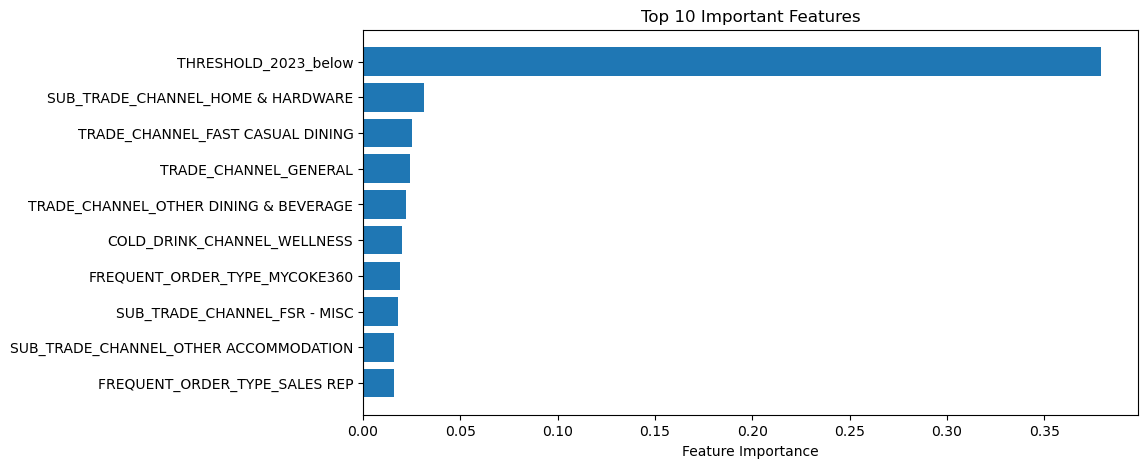

In [82]:
# Extract feature importance
feature_importance = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': best_xgb.feature_importances_
}).sort_values(by='Importance', ascending=False)

# Plot feature importance
plt.figure(figsize=(10, 5))
plt.barh(feature_importance['Feature'][:10], feature_importance['Importance'][:10])
plt.gca().invert_yaxis()  # Flip highest importance to top
plt.xlabel("Feature Importance")
plt.title("Top 10 Important Features")
plt.show()

**RESULT**

The model identifies that all customers who transitioned above the threshold were initially below the threshold in 2023. As a result, it heavily weighs the `THRESHOLD_2023_below` feature as a strong predictor for transition. However, this presents a modeling issue. The prominence of this feature in determining transition likelihood is misleading, as being below the threshold is merely a prerequisite for transitioning. It is embedded in the way the transition_status variable is defined. If this bias is uncorrected, the model may incorrectly predict that large number of customers in future years, i.e 2026 will transition due to being below the threshold, without considering other meaningful predictors.

Thus, to solve this bias, `THRESHOLD_2023_below` will be removed from the dataset. `THRESHOLD_2023_above` will also be removed because the model will use this as strong predictor if `THRESHOLD_2023_below` is removed. This is because the model will observe that the customers who transition are all  _False_ in `THRESHOLD_2023_above` which will cause the model to make `THRESHOLD_2023_above` as the most important predictor.

False represents customers who are **NOT** below the threshold and these customers on average do 2,086 gallons per customer
True repseents customers who are **BELOW** the threshol and these customers on average do 112.66 gallons per customer.

## XGBoost Remodelled

The XGBoost Model will be remodelled with a grid search to identify the best ROC-AUC score and Recall score. The threshold variables as previously mentioned will also be dropped. The model will be called Remodelled XGBoost.

### Prepare Data for Grid Search

#### Copy Dataset

In [59]:
# Create copy from original dataset
sccu_segmentation_02 = sccu.copy()

Dataset will be copied and recleaned to avoid confusion with the previous dataset.

#### Recreate Transition Status Variable

In [60]:
# See the string documentation for more info about the transition_status function.
# To summarize, transition_status(dataframe, value for up, value for down, remain above threshold, remain below threshold)
# 1 represents UP which is the scenario to be modelled while zero is used for all the other scenarios, converts this to a binary scenario.
sccu_segmentation_02 = transition_status(sccu_segmentation_02,1,0,0,0)

True


I added in a print statement that checks if the transition status is inside of the function. If it is, then this function will print True which also can be used to make sure that the code worked.

In [61]:
# Redefine the Cleaning Dataset to impute the AVG_ORDER_VOLUME_2023 with zero.
def cleaning_data(dataset):
    # Drop these columns from the dataset. Threshold_2024 and other 2024 related variables are "future variable" and the other variables will not help with prediction
    transformed_df = dataset.drop(columns=['FIRST_TRANSACTION_DATE', 'LAST_TRANSACTION_DATE',"FIRST_DELIVERY_DATE","ON_BOARDING_DATE","Unnamed: 0","CUSTOMER_NUMBER", "PRIMARY_GROUP_NUMBER","ZIP_CODE",
                                 'TRANS_DAYS',"TRANS_COUNT_2024","ANNUAL_VOLUME_CASES_2024","ANNUAL_VOLUME_GALLON_2024",'ANNUAL_VOLUME_2024', 'TRANS_COUNT',
                                 'AVG_ORDER_VOLUME_2024','CHANGED_VOLUME','PERCENT_CHANGE',"THRESHOLD_2024","DELIVERY_COST_2024_GALLON",
                                 "DELIVERY_COST_2024","DELIVERY_COST_2024_CASES","THRESHOLD_2023"])

    # Create list with following variables to one hot encode
    categorical_cols = ['FREQUENT_ORDER_TYPE','COLD_DRINK_CHANNEL','TRADE_CHANNEL','SUB_TRADE_CHANNEL', 'STATE_SHORT']

    # Convert variables to one hot encoded dummy variables and assign back to transformed df.
    transformed_df = pd.get_dummies(transformed_df, columns=categorical_cols, drop_first=True)

    # Impute AVG_ORDER_VOLUME_2023 with zero gallons
    transformed_df['AVG_ORDER_VOLUME_2023'] = transformed_df['AVG_ORDER_VOLUME_2023'].fillna(0)

    # Drop missing values from remaining columns. Confirmed to be: DELIVERY_COST_2023_CASES, DELIVERY_COST_2023_GALLON, DELIVERY_COST_2023 
    transformed_df = transformed_df.dropna()

    # Return the Dataset
    return transformed_df

The cleaning_data function will again be redefined, so that the threshold variable is dropped for future models. Otherwise, it must be manually dropped for future models.

In [62]:
# Apply cleaning function to this new dataset
sccu_segmentation_02 = cleaning_data(sccu_segmentation_02)

# See the first few rows to verify this was sucessful
sccu_segmentation_02.head()

,TRANS_COUNT_2023,ANNUAL_VOLUME_CASES_2023,ANNUAL_VOLUME_GALLON_2023,ANNUAL_VOLUME_2023,AVG_ORDER_VOLUME_2023,LOCAL_MARKET_PARTNER,CO2_CUSTOMER,DELIVERY_COST_2023_CASES,DELIVERY_COST_2023_GALLON,DELIVERY_COST_2023,...,SUB_TRADE_CHANNEL_PRIMARY SCHOOL,SUB_TRADE_CHANNEL_RECREATION ARENA,SUB_TRADE_CHANNEL_RECREATION FILM,SUB_TRADE_CHANNEL_RECREATION PARK,SUB_TRADE_CHANNEL_RESIDENTIAL,SUB_TRADE_CHANNEL_SANDWICH FAST FOOD,STATE_SHORT_KY,STATE_SHORT_LA,STATE_SHORT_MA,STATE_SHORT_MD
0,27,210.0,160.0,370.0,13.703704,True,True,938.785885,428.063964,1366.849849,...,False,False,False,False,False,False,False,False,False,False
1,46,24.0,577.5,601.5,13.076087,True,True,206.051579,1163.368809,1369.420388,...,False,False,False,False,False,False,False,False,False,True
2,5,17.5,0.0,17.5,3.500000,True,False,128.200325,0.000000,128.200325,...,False,False,False,False,False,False,False,False,True,False
3,9,0.0,125.0,125.0,13.888889,True,True,0.000000,470.060235,470.060235,...,False,False,False,False,False,False,True,False,False,False
4,40,124.0,422.5,546.5,13.662500,True,False,1064.599825,1069.832321,2134.432146,...,False,False,False,False,False,False,True,False,False,False


The head function has been called to make sure that the changes were successful which was the case.

### Grid Search

In [63]:
# Split code into X_dataset with all explanatory variables and target which only contains the target variable.
X_dataset, target = cross_validation(sccu_segmentation_02)

The code will split the data into X_dataset which contains all the explanatory variables and target dataset which is only contains the target variable.

In [64]:
# Split the dataset
X_train, X_test, y_train, y_test = train_test_split(
    X_dataset, target, test_size=0.2, stratify=target, random_state=42
)

# Apply SMOTE to balance the training set
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

# Define the XGBoost model
xgb_model = XGBClassifier(use_label_encoder=False, eval_metric="logloss", random_state=42)

# Define hyperparameter grid
param_grid = {
    'n_estimators': [50, 100, 200],       # Number of trees
    'max_depth': [3, 5, 7],               # Tree depth
    'learning_rate': [0.01, 0.1, 0.3],    # Step size shrinkage
    'subsample': [0.8, 1.0],              # Fraction of samples used per tree
    'colsample_bytree': [0.8, 1.0],       # Fraction of features used per tree
    'gamma': [0, 1, 5]                    # Minimum loss reduction for further splitting
}

# Perform GridSearch with 5-fold cross-validation
grid_search = GridSearchCV(
    estimator=xgb_model,
    param_grid=param_grid,
    scoring='roc_auc',
    cv=5,
    n_jobs=-1,  # Use all available cores
    verbose=2
)

# Fit the model on resampled training data
grid_search.fit(X_train_resampled, y_train_resampled)

# Get the best model
best_xgb = grid_search.best_estimator_

# Evaluate on the test set
y_test_pred = best_xgb.predict_proba(X_test)[:, 1]  # Get probabilities
test_roc_auc = roc_auc_score(y_test, y_test_pred)

# Print results
print(f"Best Parameters: {grid_search.best_params_}")
print(f"Test ROC-AUC Score: {test_roc_auc:.4f}")


Fitting 5 folds for each of 324 candidates, totalling 1620 fits


c:\Users\varun\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [19:43:02] WARNING: C:\b\abs_90_bwj_86a\croot\xgboost-split_1724073762025\work\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Best Parameters: {'colsample_bytree': 1.0, 'gamma': 0, 'learning_rate': 0.3, 'max_depth': 7, 'n_estimators': 200, 'subsample': 0.8}
Test ROC-AUC Score: 0.8796


### Train and Test Datasets

In [74]:
print("Best Parameters:", grid_search.best_params_)

# Get predictions
y_train_pred_proba = best_xgb.predict_proba(X_train)[:, 1]  # Probabilities
y_test_pred_proba = best_xgb.predict_proba(X_test)[:, 1]

# Compute ROC-AUC
train_roc_auc = roc_auc_score(y_train, y_train_pred_proba)
test_roc_auc = roc_auc_score(y_test, y_test_pred_proba)

print(f"Train ROC-AUC: {train_roc_auc:.4f}")
print(f"Test ROC-AUC: {test_roc_auc:.4f}")

Best Parameters: {'colsample_bytree': 1.0, 'gamma': 0, 'learning_rate': 0.3, 'max_depth': 7, 'n_estimators': 200, 'subsample': 0.8}
Train ROC-AUC: 0.9807
Test ROC-AUC: 0.8796


|    Model           | Train ROC-AUC    | Test ROC-AUC       | Difference | 
|--------------------|------------------|--------------------|------------|          
| Original XGBoost   |0.9993            | 0.9080             | 0.0913     | 
| Remodelled XGBoost |     0.9807       | 0.8796             | 0.1011     |

The above table shows the Train ROC-AUC and Test ROC-AUC for the Original XGBoost model and the Remodelled XGBoost model. (The original XGBoost model had the threshold variables.)

The decline in Train ROC-AUC to Test ROC-AUC is very similar in both models. There is only a difference of 0.97 between the scores which is very small. This indicates that removing the threshold variables had a very minimal impact on the model's predictive capabalities.

### Top Predictors

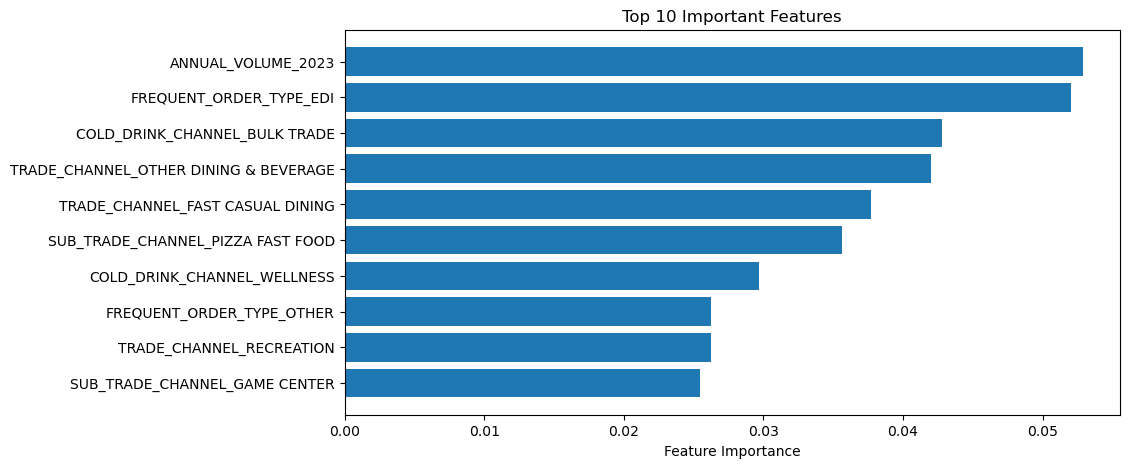

In [75]:
# Extract feature importance
feature_importance = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': best_xgb.feature_importances_
}).sort_values(by='Importance', ascending=False)

# Plot feature importance
plt.figure(figsize=(10, 5))
plt.barh(feature_importance['Feature'][:10], feature_importance['Importance'][:10])
plt.gca().invert_yaxis()  # Flip highest importance to top
plt.xlabel("Feature Importance")
plt.title("Top 10 Important Features")
plt.show()

The top predictor is ANNUAL_VOLUME_2023 which appeared in several of the iterative decision trees that were created. It however is unknown, if `ANNUAL_VOLUME_2023` is associated with the Target Variable in a negative way. For instance, the model may note that customers who go from "Below the Threshold" to 'Above the Threshold" have lower volumes at the beginning. Thus, it might suggest that customers who transact less volume have a higher chance of transitioning. The XGBoost model will currently not provide that information, but this info can be found from a whitebox model such as Logistic Regression.

In [81]:
# List all the top predictors of the original model in a set 
Original_XGBoost_Top_Predictors = {'THRESHOLD_2023_below','SUB_TRADE_CHANNEL_HOME & HARDWARE',
'TRADE_CHANNEL_FAST CASUAL_DINING','TRADE_CHANNEL_GENERAL','TRADE_CHANNEL_OTHER DINING AND BEVERAGE',
'COLD_DRINK_CHANNEL_WELLNESS','FREQUENT_ORDER_TYPE_MYCOKE_360', 'SUB_TRADE_CHANNEL_FSR_MISC',
'SUB_TRADE_CHANNEL_OTHER_ACCOMODATION','FREQUENT_ORDER_TYPE_SALES REP'}

# List all the top predictors of the remodelled model in a set 
Remodelled_XGBoost_Top_Predictors = {'ANNUAL_VOLUME_2023','FREQUENT_ORDER_TYPE_EDI','COLD_DRINK_CHANNEL_BULK TRADE',
'TRADE_CHANNEL_OTHER DINING AND BEVERAGE','TRADE_CHANNEL_FAST CASUAL_DINING','SUB_TRADE_CHANNEL_PIZZA FAST FOOD',
'COLD_DRINK_CHANNEL_WELLNESS','FREQUENT_ORDER_TYPE_OTHER','TRADE_CHANNEL_RECREATION','SUB_TRADE_CHANNEL_GAME CENTER'}

print("Predictors found in both models:\n",Original_XGBoost_Top_Predictors.intersection(Remodelled_XGBoost_Top_Predictors))

Predictors found in both models:
 {'TRADE_CHANNEL_FAST CASUAL_DINING', 'TRADE_CHANNEL_OTHER DINING AND BEVERAGE', 'COLD_DRINK_CHANNEL_WELLNESS'}


The above code shows how many predictors are in both models. There are only 3 common predictors which indicates that getting the rid of the threshold variable really changed the top predictors.

## XGBoost New Threshold

The XGBoost model will be remodelled with the new threshold discovered by my team. The new threshold is 300 gallons.

### Data Cleaning

In [130]:
# Make a copy of the original data for cleaning
sccu_segmentation_03 = sccu.copy()

#### Recreate the Transition Variable

In [131]:
sccu_segmentation_03 = transition_status(sccu_segmentation_03,1,0,0,0,"Threshold_2023_300_below",
                                         "Threshold_2024_300_below",300,"ANNUAL_VOLUME_2023",
                                         "ANNUAL_VOLUME_2024")

True
New Threshold Sucessfully Created


Since the function outputted true, this means that the new threshold columns have been sucessfully added.

#### Finish Cleaning Data

In [132]:
sccu_segmentation_03 = cleaning_data(sccu_segmentation_03)

In [ ]:
sccu_segmentation_03 = sccu_segmentation_03.drop(columns=['Threshold_2024_300_below',
                                                          "Threshold_2023_300_below"])

The first code block just runs the cleaning_data function on this dataset while the second code block drops `Threshold_2024_300_below` and `Threshold_2023_300_below` from the dataset. This is required due to the previous explanation for why the thresholds should not be used for prediction.

In [134]:
sccu_segmentation_03.head()

,TRANS_COUNT_2023,ANNUAL_VOLUME_CASES_2023,ANNUAL_VOLUME_GALLON_2023,ANNUAL_VOLUME_2023,AVG_ORDER_VOLUME_2023,LOCAL_MARKET_PARTNER,CO2_CUSTOMER,DELIVERY_COST_2023_CASES,DELIVERY_COST_2023_GALLON,DELIVERY_COST_2023,...,SUB_TRADE_CHANNEL_PRIMARY SCHOOL,SUB_TRADE_CHANNEL_RECREATION ARENA,SUB_TRADE_CHANNEL_RECREATION FILM,SUB_TRADE_CHANNEL_RECREATION PARK,SUB_TRADE_CHANNEL_RESIDENTIAL,SUB_TRADE_CHANNEL_SANDWICH FAST FOOD,STATE_SHORT_KY,STATE_SHORT_LA,STATE_SHORT_MA,STATE_SHORT_MD
0,27,210.0,160.0,370.0,13.703704,True,True,938.785885,428.063964,1366.849849,...,False,False,False,False,False,False,False,False,False,False
1,46,24.0,577.5,601.5,13.076087,True,True,206.051579,1163.368809,1369.420388,...,False,False,False,False,False,False,False,False,False,True
2,5,17.5,0.0,17.5,3.500000,True,False,128.200325,0.000000,128.200325,...,False,False,False,False,False,False,False,False,True,False
3,9,0.0,125.0,125.0,13.888889,True,True,0.000000,470.060235,470.060235,...,False,False,False,False,False,False,True,False,False,False
4,40,124.0,422.5,546.5,13.662500,True,False,1064.599825,1069.832321,2134.432146,...,False,False,False,False,False,False,True,False,False,False


Use the head function to check that everything looks sucessful which in this case it does.

### Setup Cross Validation

In [ ]:
# Split into explanatory variables and target variable respectively
X_dataset_01,target_01 = cross_validation(sccu_segmentation_03)

In [116]:
# Drop rows with NaN values from X and y
X_dataset_01 = X_dataset_01.dropna()
target_01= target_01[X_dataset_01.index]  # Ensure that y is aligned with the cleaned X

# Check that there are no NaN values left in X and y
print(X_dataset_01.isna().sum())  # Should show 0 for all columns
print(target_01.isna().sum())  # Should show 0 for the target variable

TRANS_COUNT_2023                        0
ANNUAL_VOLUME_CASES_2023                0
ANNUAL_VOLUME_GALLON_2023               0
ANNUAL_VOLUME_2023                      0
AVG_ORDER_VOLUME_2023                   0
                                       ..
SUB_TRADE_CHANNEL_SANDWICH FAST FOOD    0
STATE_SHORT_KY                          0
STATE_SHORT_LA                          0
STATE_SHORT_MA                          0
STATE_SHORT_MD                          0
Length: 99, dtype: int64
0


Do a quick check to make sure that there are no missing values. In this case there are no missing values which is good.

### Grid Search

In [117]:
# Split the dataset
X_train, X_test, y_train, y_test = train_test_split(
    X_dataset_01, target_01, test_size=0.2, stratify=target_01, random_state=42
)

# Apply SMOTE to balance the training set
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

# Define the XGBoost model
xgb_model = XGBClassifier(use_label_encoder=False, eval_metric="logloss", random_state=42)

# Define hyperparameter grid
param_grid = {
    'n_estimators': [50, 100, 200], # Number of trees
    'max_depth': [3, 5, 7],               # Tree depth
    'learning_rate': [0.01, 0.1, 0.3],    # Step size shrinkage
    'subsample': [0.8, 1.0],              # Fraction of samples used per tree
    'colsample_bytree': [0.8, 1.0],       # Fraction of features used per tree
    'gamma': [0, 1, 5]                    # Minimum loss reduction for further splitting
}

# Perform GridSearch with 5-fold cross-validation
grid_search = GridSearchCV(
    estimator=xgb_model,
    param_grid=param_grid,
    scoring='roc_auc',
    cv=5,
    n_jobs=-1,
    verbose=2
)

# Fit the model on resampled training data
grid_search.fit(X_train_resampled, y_train_resampled)

# Get the best model
best_xgb = grid_search.best_estimator_

# Evaluate on the test set
y_test_pred = best_xgb.predict_proba(X_test)[:, 1]  # Get probabilities
test_roc_auc = roc_auc_score(y_test, y_test_pred)

# Print results
print(f"Best Parameters: {grid_search.best_params_}")
print(f"Test ROC-AUC Score: {test_roc_auc:.4f}")

Fitting 5 folds for each of 324 candidates, totalling 1620 fits


c:\Users\varun\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [22:59:24] WARNING: C:\b\abs_90_bwj_86a\croot\xgboost-split_1724073762025\work\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Best Parameters: {'colsample_bytree': 0.8, 'gamma': 0, 'learning_rate': 0.3, 'max_depth': 7, 'n_estimators': 200, 'subsample': 0.8}
Test ROC-AUC Score: 0.8811


### Train and Test Datasets

In [118]:
print("Best Parameters:", grid_search.best_params_)

# Get predictions
y_train_pred_proba = best_xgb.predict_proba(X_train)[:, 1]  # Probabilities
y_test_pred_proba = best_xgb.predict_proba(X_test)[:, 1]

# Compute ROC-AUC
train_roc_auc = roc_auc_score(y_train, y_train_pred_proba)
test_roc_auc = roc_auc_score(y_test, y_test_pred_proba)

print(f"Train ROC-AUC: {train_roc_auc:.4f}")
print(f"Test ROC-AUC: {test_roc_auc:.4f}")

Best Parameters: {'colsample_bytree': 0.8, 'gamma': 0, 'learning_rate': 0.3, 'max_depth': 7, 'n_estimators': 200, 'subsample': 0.8}
Train ROC-AUC: 0.9734
Test ROC-AUC: 0.8811


|    Model                          | Train ROC-AUC    | Test ROC-AUC       | Difference | 
|---------------------------------- |------------------|--------------------|------------|          
|XGBoost Original Threshold (400 Gallons)   |0.9807             | .8796     | 0.0913     | 
|XGBoost new Threshold (300 Gallons)        |0.9734             | 0.8811    |0.0923      |

XGboost with the new threshold performs very similarily to XGboost with the old threshold in terms of predictive power. The difference between train and test is .0923 which is very close to the old threshold model with a difference of .0193. This is a difference of .0010 which is very small.

### Top Predictors

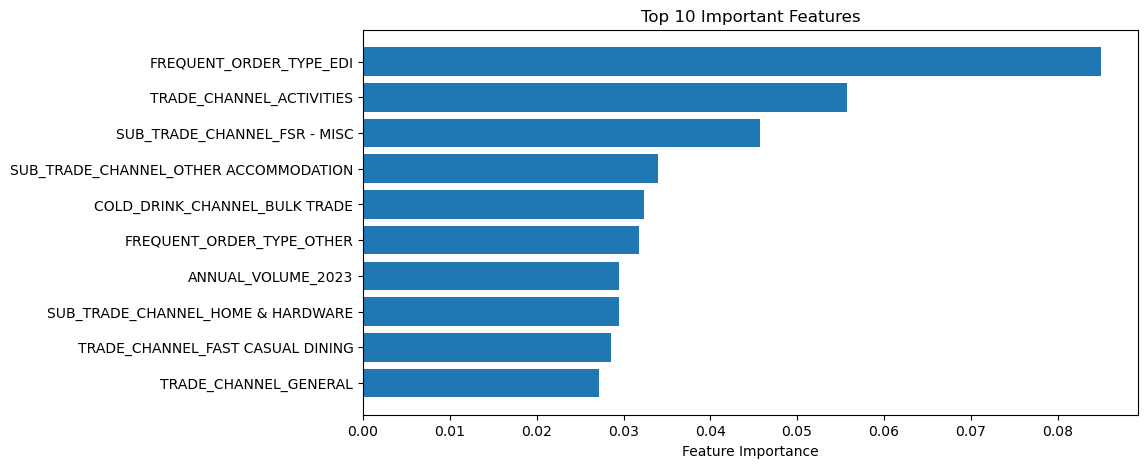

In [119]:
# Extract feature importance
feature_importance = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': best_xgb.feature_importances_
}).sort_values(by='Importance', ascending=False)

# Plot feature importance
plt.figure(figsize=(10, 5))
plt.barh(feature_importance['Feature'][:10], feature_importance['Importance'][:10])
plt.gca().invert_yaxis()  # Flip highest importance to top
plt.xlabel("Feature Importance")
plt.title("Top 10 Important Features")
plt.show()

This graph shows the top predictors for this XGBoost model. Interestingly ANNUAL_VOLUME_2023 is no longer one of the top 3 predictors. This model's predictors however need to still be compared with the old threshold predictors.

In [122]:
# XGboost model for 400 gallons
Remodelled_XGBoost_Top_Predictors

# XGBoost model for 300 gallons
Remodelled_300_GAL_XGBoost_Top_Predictors = {'FREQUENT_ORDER_TYPE_EDI',
'TRADE_CHANNEL_ACTIVITIES','SUB_TRADE_CHANNEL_FSR-MSC','SUB_TRADE_CHANNEL_OTHER ACCOMODATION',
'COLD_DRINK_CHANNEL_BULK_TRADE','FREQUENT_ORDER_TYPE_OTHER','ANNUAL_VOLUME_2023',
'SUB_TRADE_CHANNEL_HOME & HARDWARE','TRADE_CHANNEL_FAST_CASUAL_DINING','TRADE_CHANNEL_GENERAL'}

print("Common Predictors:\n", Remodelled_XGBoost_Top_Predictors.intersection(Remodelled_300_GAL_XGBoost_Top_Predictors))

Common Predictors:
 {'ANNUAL_VOLUME_2023', 'FREQUENT_ORDER_TYPE_EDI', 'FREQUENT_ORDER_TYPE_OTHER'}


The change in threshold has caused the predictors to change again. THe overall performance is the same, however the predictors have changed which suggests that the lower threshold has enabled some predictors to become very important.

## Logistic Regression 

Logistic Regression is a whitebox model that can provide more insights into how a model makes it decision via coefficients. It should be noted that these coefficients are in log-odds, however the sign and the scale of the coefficient can be used to make comparisons and guage the effects of various predictors.

Logistic Regression can also be used to answer the first question at the beginning along with the second question: 

* Can customers be segmented into different groups based on their probability of transitoning? For instance:
    * 25% chance of transitioning - Low
    * 55% chance of transitioning - Medium
    * 75% chance of transitioning - High
    * 95% chance of transitioning - Very High

Logistic Regression will be better for the second question, since it provides insights into how it makes its decisions. This will make it easy to consequently identify charactersitics of the customers in each of these segments.

### New Threshold

#### Cleaning Data

The values are missing for Avg_Order_Volume because the customer did not process any volumes, gallons, etc. for that year. Thus, to address `AVG_ORDER_VOLUME_2023`'s missing values, zero will be imputed in place of the missing value.

#### Grid Search
This is a grid search with the new threshold (300 Gallons)

In [8]:
sccu_segmentation_03_1 = sccu.copy()
sccu_segmentation_03_1 = transition_status(sccu_segmentation_03_1,1,0,0,0,
                                           "THRESHOLD_2023_300","THRESHOLD_2024_300",300,"ANNUAL_VOLUME_2023",
                                           "ANNUAL_VOLUME_2024")
sccu_segmentation_03_1 = cleaning_data(sccu_segmentation_03_1)
sccu_segmentation_03_1 = sccu_segmentation_03_1.drop(["THRESHOLD_2023_300","THRESHOLD_2024_300"],axis=1)

X,y = cross_validation(sccu_segmentation_03_1)

# Step 1: Train-test split (with stratification)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42

# Step 3: Build pipeline with SMOTE, StandardScaler, and Logistic Regression
pipeline = ImbPipeline(steps=[
    ('smote', SMOTE(random_state=42)),
    ('scaler', StandardScaler()),
    ('logreg', LogisticRegression(solver='liblinear'))  # 'liblinear' works well for smaller datasets
])

# Step 4: Hyperparameter grid
param_grid = {
    'logreg__C': [0.01, 0.1, 1, 10],      # Regularization strength
    'logreg__penalty': ['l1', 'l2']            # Regularization type
}

# Step 5: Grid Search with 5-fold CV
grid_search = GridSearchCV(
    estimator=pipeline,
    param_grid=param_grid,
    scoring='roc_auc',
    cv=5,
    verbose=2,
    n_jobs=-1
)

# Step 6: Fit model
grid_search.fit(X_train, y_train)

# Step 7: Evaluate performance
best_model = grid_search.best_estimator_
y_test_pred = best_model.predict_proba(X_test)[:, 1]
test_roc_auc = roc_auc_score(y_test, y_test_pred)

# Step 8: Print results
print("Best Parameters:", grid_search.best_params_)
print(f"Test ROC-AUC Score: {test_roc_auc:.4f}")

True
New Threshold Sucessfully Created
Fitting 5 folds for each of 8 candidates, totalling 40 fits


c:\Users\varun\anaconda3\Lib\site-packages\joblib\externals\loky\backend\context.py:136: UserWarning: Could not find the number of physical cores for the following reason:
[WinError 2] The system cannot find the file specified
Returning the number of logical cores instead. You can silence this warning by setting LOKY_MAX_CPU_COUNT to the number of cores you want to use.
  warnings.warn(
  File "c:\Users\varun\anaconda3\Lib\site-packages\joblib\externals\loky\backend\context.py", line 257, in _count_physical_cores
    cpu_info = subprocess.run(
               ^^^^^^^^^^^^^^^
  File "c:\Users\varun\anaconda3\Lib\subprocess.py", line 548, in run
    with Popen(*popenargs, **kwargs) as process:
         ^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\varun\anaconda3\Lib\subprocess.py", line 1026, in __init__
    self._execute_child(args, executable, preexec_fn, close_fds,
  File "c:\Users\varun\anaconda3\Lib\subprocess.py", line 1538, in _execute_child
    hp, ht, pid, tid = _winapi.CreatePro

Best Parameters: {'logreg__C': 10, 'logreg__penalty': 'l1'}
Test ROC-AUC Score: 0.7613


The best parameters are Ridge Regresion with a high cost of 10 to discourage very large coefficients. This model is a bit lower than the XGBoost which had an ROC-AUC of .8811 for the new threshold. The difference between these two models is 14.4%. The train ROC-AUC still has to be evaluated though.

In [135]:
print("Best Parameters:", grid_search.best_params_)

# Get predictions
y_train_pred_proba = best_model.predict_proba(X_train)[:, 1]  # Probabilities
y_test_pred_proba = best_model.predict_proba(X_test)[:, 1]

# Compute ROC-AUC
train_roc_auc = roc_auc_score(y_train, y_train_pred_proba)
test_roc_auc = roc_auc_score(y_test, y_test_pred_proba)

print(f"Train ROC-AUC: {train_roc_auc:.4f}")
print(f"Test ROC-AUC: {test_roc_auc:.4f}")

Best Parameters: {'logreg__C': 10, 'logreg__penalty': 'l2'}
Train ROC-AUC: 0.7306
Test ROC-AUC: 0.7371


The Train ROC-AUC and Test ROC-AUC are much closer to each other which indicates that this model is does a better job at generalizing towards new unseen data compared to the XGBoost model which had a 9-10% decline between Train and Test Sets.

#### Model Coefficients

In [136]:
# Get the feature names from the original data
feature_names = X_train.columns

# Get the logistic regression model from the pipeline
logreg_model = best_model.named_steps["logreg"]

# Get the coefficients
coefficients = logreg_model.coef_[0]

# Combine names and coefficients into a DataFrame
coef_df = pd.DataFrame({
    "Feature": feature_names,
    "Coefficient": coefficients,
    "Abs_Coefficient": np.abs(coefficients)
})

# Sort by absolute value of the coefficients
top_predictors = coef_df.sort_values(by="Abs_Coefficient", ascending=False)

print(top_predictors.head(10))  # Top 10 predictors

                                   Feature  Coefficient  Abs_Coefficient
29        TRADE_CHANNEL_FAST CASUAL DINING     3.962868         3.962868
1                 ANNUAL_VOLUME_CASES_2023    -3.494896         3.494896
3                       ANNUAL_VOLUME_2023    -3.096573         3.096573
14           FREQUENT_ORDER_TYPE_SALES REP     2.830475         2.830475
62       SUB_TRADE_CHANNEL_HOME & HARDWARE     2.481518         2.481518
74  SUB_TRADE_CHANNEL_OTHER GENERAL RETAIL     2.315545         2.315545
26      TRADE_CHANNEL_COMPREHENSIVE DINING     2.117995         2.117995
59            SUB_TRADE_CHANNEL_FSR - MISC     2.117995         2.117995
13               FREQUENT_ORDER_TYPE_OTHER     2.106492         2.106492
12           FREQUENT_ORDER_TYPE_MYCOKE360     2.070011         2.070011


These are the model coefficients for the Logistic Regression Model. Two volume related variables `ANNUAL_VOLUME_CASES_2023` and `ANNUAL_VOLUME_2023` are top predictors and are both negative. This could be because the model is noting that customers who go from "Below the Threshold" to 'Above the Threshold" have lower volumes at the beginning. Thus, it might suggest that customers who transact less volume have a higher chance of transitioning.

Another reason could be multi-colinearity which will be examined in the next section. It's very possible that some of the volume related variables are correlated with each other which will cause issues with coefficient interepretation such as changing the sign and scale of the coefficient. 

Hence, to isolate this issue, multi-colinearity will first be examined and then the model will be re-ran with the same parameters. (Multi-colinearity only affects coefficient interepretation not model performance, so Grid Search does not need to be reran.)

Finally, the reason the volume related variable being negative is concerning is because it seems to suggest that customers should transact less volume which will lead to an increase in them exceeding the threshold. This does not make much sense in a real world context and must be addressed.

#### Multi-Colinearity

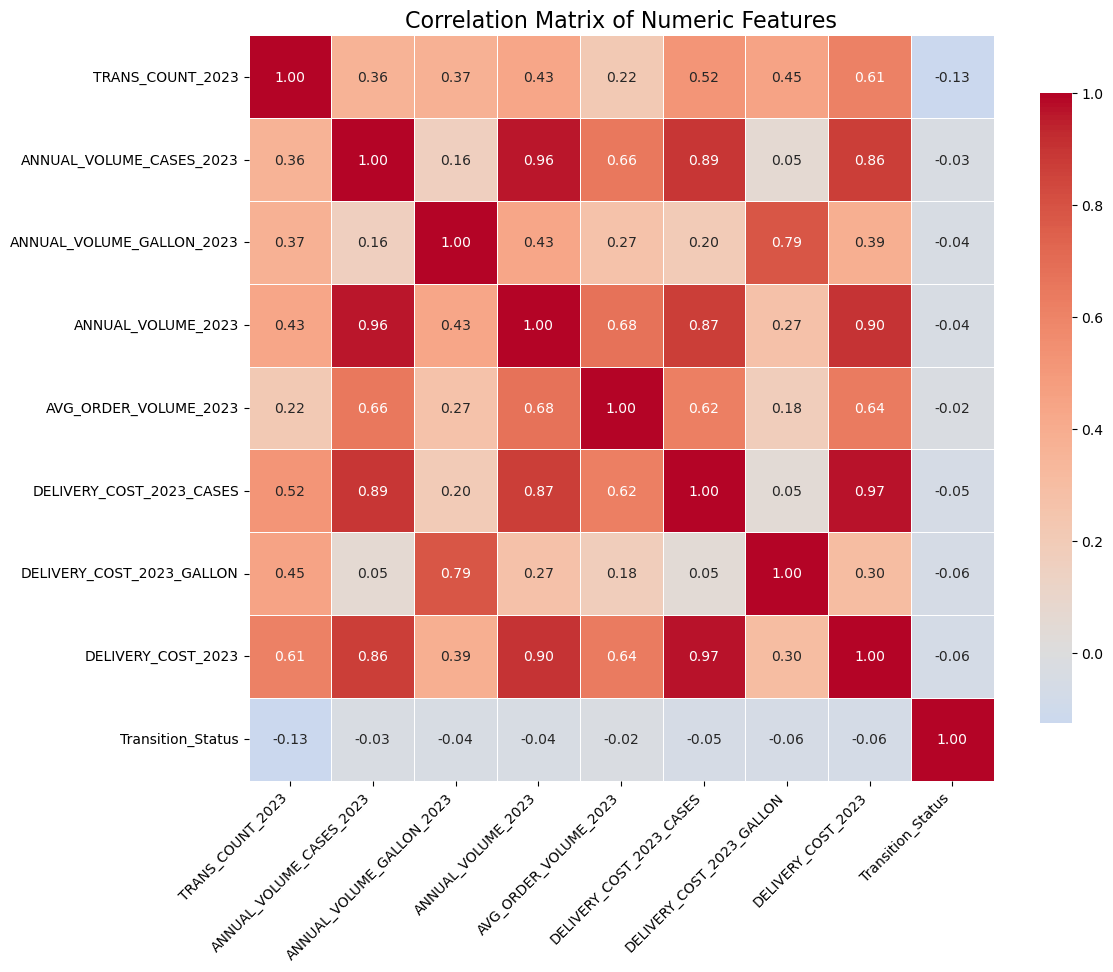

In [142]:
# Step 1: Select only numeric columns from your DataFrame
numeric_cols = sccu_segmentation_03.select_dtypes(include='number')

# Step 2: Compute the correlation matrix
corr_matrix = numeric_cols.corr()

# Step 3: Set up a heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='coolwarm', center=0, 
            square=True, linewidths=0.5, cbar_kws={"shrink": 0.8})

# Step 4: Display it
plt.title("Correlation Matrix of Numeric Features", fontsize=16)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

`ANNUAL_VOLUME_2023` and `ANNUAL_CASES_2023` are highly correlated and are the top predictors. This does however make sense because `ANNUAL_VOLUME_2023` is `ANNUAL_CASES_2023` + `ANNUAL_GALLONS_2023`. Likewise `DELIVERY_COST_2023` is highly correlated with `DELIVERY_COST_2023_CASES` at 97%. 

Interestingly, it's not as highly correlated with `DELIVERY_COST_2023_GALLONS` at only 30%. This suggests that `DELIVERY_COST_2023_CASES` is a bigger driver of cost compared to `DELIVERY_COST_2023_GALLONS`. `DELIVERY_COST_2023_CASES` is `DELIVERY_COST_2023_CASES` + `DELIVERY_COST_2023_GALLONS`.

Based of these results, `DELIVERY_COST_2023` and `ANNUAL_VOLUME_2023` will be dropped since they are derived from the other variables are highly correlated. They are also highly correlated with each other as well at 90%.

In [ ]:
sccu_segmentation_03 = sccu_segmentation_03.drop(['DELIVERY_COST_2023','ANNUAL_VOLUME_2023'],axis=1)

In [149]:
print('DELIVERY_COST_2023' in sccu_segmentation_03.columns)
print('ANNUAL_VOLUME_2023' in sccu_segmentation_03.columns)

False
False


The columns have been dropped sucessfully, since the last code shows False for both columns which indicates that they are not in the dataset anymore.

In [150]:
# Step 1: Separate predictors and target
X = sccu_segmentation_03.drop(columns=["Transition_Status"])
y = sccu_segmentation_03["Transition_Status"]

# Drop rows in X *and* y where X has missing values
X = X.dropna()
y = y.loc[X.index]  # Align y with the filtered X

# Step 2: Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

# Step 3: Build and train the pipeline with the best parameters
final_model = ImbPipeline(steps=[
    ('smote', SMOTE(random_state=42)),
    ('scaler', StandardScaler()),
    ('logreg', LogisticRegression(C=10, penalty='l2', solver='liblinear'))
])

# Step 4: Fit the model
final_model.fit(X_train, y_train)

# Step 5: Evaluate performance
y_train_pred_prob = final_model.predict_proba(X_train)[:,1]
y_test_pred_pob = final_model.predict_proba(X_test)[:,1]
train_roc_auc = roc_auc_score(y_train,y_train_pred_prob)
test_roc_auc = roc_auc_score(y_test,y_test_pred_pob)
print(f"Final Model Train ROC-AUC: {train_roc_auc:.4f}")
print(f"Final Model Test ROC-AUC: {test_roc_auc:.4f}")

Final Model Train ROC-AUC: 0.7308
Final Model Test ROC-AUC: 0.7368


This is very similar to the best model from the grid search which also had a Train and Test ROC-AUC of .73. This model actually does slightly improves performance on the Test Set when compared to the Train Set.

##### Numeric Coefficients

In [152]:
# Get the feature names from the original data
feature_names = X_train.columns

# Get the logistic regression model from the pipeline
logreg_model = final_model.named_steps["logreg"]

# Get the coefficients
coefficients = logreg_model.coef_[0]

# Combine names and coefficients into a DataFrame
coef_df = pd.DataFrame({
    "Feature": feature_names,
    "Coefficient": coefficients,
    "Abs_Coefficient": np.abs(coefficients)
})

# Sort by absolute value of the coefficients
top_predictors = coef_df.sort_values(by="Abs_Coefficient", ascending=False)

print(top_predictors.head(10))  # Top 10 predictors

                                   Feature  Coefficient  Abs_Coefficient
1                 ANNUAL_VOLUME_CASES_2023    -6.274713         6.274713
27        TRADE_CHANNEL_FAST CASUAL DINING     3.965219         3.965219
12           FREQUENT_ORDER_TYPE_SALES REP     2.800112         2.800112
60       SUB_TRADE_CHANNEL_HOME & HARDWARE     2.476605         2.476605
72  SUB_TRADE_CHANNEL_OTHER GENERAL RETAIL     2.334521         2.334521
57            SUB_TRADE_CHANNEL_FSR - MISC     2.117230         2.117230
24      TRADE_CHANNEL_COMPREHENSIVE DINING     2.117230         2.117230
11               FREQUENT_ORDER_TYPE_OTHER     2.080846         2.080846
10           FREQUENT_ORDER_TYPE_MYCOKE360     2.044428         2.044428
70          SUB_TRADE_CHANNEL_OTHER DINING     1.978017         1.978017


`ANNUAL_VOLUME_CASES_2023` is still negative which is still problematic.. The reason could still be multi-colinearity or due to how `Transition_Status` was created. Instead of looking at correlation maps directly, Variance Inflation Factor to get a more direct look at which variables are highly correlated.

In [153]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant

# Step 1: Select numeric columns only
numeric_cols = X.select_dtypes(include=['int64', 'float64'])

# Step 2: Add a constant column for intercept
X_numeric = add_constant(numeric_cols)

# Step 3: Calculate VIFs
vif_data = pd.DataFrame()
vif_data["feature"] = X_numeric.columns
vif_data["VIF"] = [variance_inflation_factor(X_numeric.values, i) for i in range(X_numeric.shape[1])]

# Step 4: Display results (excluding intercept if you want)
print(vif_data.sort_values(by="VIF", ascending=False))

                     feature       VIF
5   DELIVERY_COST_2023_CASES  7.576115
2   ANNUAL_VOLUME_CASES_2023  5.830203
6  DELIVERY_COST_2023_GALLON  3.564984
3  ANNUAL_VOLUME_GALLON_2023  2.921047
0                      const  2.415772
1           TRANS_COUNT_2023  2.236352
4      AVG_ORDER_VOLUME_2023  1.950416


`DELIVERY_COST_2023_CASES` is highly correlated with several of the variables with a VIF of 7.58. The next highest is `ANNUAL_VOLUME_CASES_2023` at 5.83. While these are both moderately high, it can still caues issues when trying to interpret the coefficients. Thus, these two variables will be dropped.

In [154]:
sccu_segmentation_03 = sccu_segmentation_03.drop(['DELIVERY_COST_2023_CASES','ANNUAL_VOLUME_CASES_2023'],axis=1)

In [155]:
# Step 1: Separate predictors and target
X = sccu_segmentation_03.drop(columns=["Transition_Status"])
y = sccu_segmentation_03["Transition_Status"]

# Drop rows in X *and* y where X has missing values
X = X.dropna()
y = y.loc[X.index]  # Align y with the filtered X

# Step 2: Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

# Step 3: Build and train the pipeline with the best parameters
final_model = ImbPipeline(steps=[
    ('smote', SMOTE(random_state=42)),
    ('scaler', StandardScaler()),
    ('logreg', LogisticRegression(C=10, penalty='l2', solver='liblinear'))
])

# Step 4: Fit the model
final_model.fit(X_train, y_train)

# Step 5: Evaluate performance
y_train_pred_prob = final_model.predict_proba(X_train)[:,1]
y_test_pred_pob = final_model.predict_proba(X_test)[:,1]
train_roc_auc = roc_auc_score(y_train,y_train_pred_prob)
test_roc_auc = roc_auc_score(y_test,y_test_pred_pob)
print(f"Final Model Train ROC-AUC: {train_roc_auc:.4f}")
print(f"Final Model Test ROC-AUC: {test_roc_auc:.4f}")

# Get the feature names from the original data
feature_names = X_train.columns

# Get the logistic regression model from the pipeline
logreg_model = final_model.named_steps["logreg"]

# Get the coefficients
coefficients = logreg_model.coef_[0]

# Combine names and coefficients into a DataFrame
coef_df = pd.DataFrame({
    "Feature": feature_names,
    "Coefficient": coefficients,
    "Abs_Coefficient": np.abs(coefficients)
})

# Sort by absolute value of the coefficients
top_predictors = coef_df.sort_values(by="Abs_Coefficient", ascending=False)

print(top_predictors.head(10))  # Top 10 predictors

Final Model Train ROC-AUC: 0.7193
Final Model Test ROC-AUC: 0.7256
                                         Feature  Coefficient  Abs_Coefficient
25              TRADE_CHANNEL_FAST CASUAL DINING     4.009082         4.009082
58             SUB_TRADE_CHANNEL_HOME & HARDWARE     2.568820         2.568820
10                 FREQUENT_ORDER_TYPE_SALES REP     2.520331         2.520331
70        SUB_TRADE_CHANNEL_OTHER GENERAL RETAIL     2.415206         2.415206
27                TRADE_CHANNEL_GENERAL RETAILER     2.127174         2.127174
55                  SUB_TRADE_CHANNEL_FSR - MISC     2.097947         2.097947
22            TRADE_CHANNEL_COMPREHENSIVE DINING     2.097947         2.097947
34         TRADE_CHANNEL_OTHER DINING & BEVERAGE     1.977378         1.977378
68                SUB_TRADE_CHANNEL_OTHER DINING     1.977378         1.977378
66  SUB_TRADE_CHANNEL_OTHER ACADEMIC INSTITUTION     1.954024         1.954024


The Train and Test ROC-AUC was .73 originally in the previous model which suggests that one of the predictors may have been slightly important when compared to this model. This model had a 1-2% drop and now shows 0.7193 for Train ROC-AUC and 0.7256 for Test ROC-AUC. This however is a very slight decline, thus, this model won't be modified further.

It should be noted that not all the predictors are not volume related. This is not necessarily a bad thing however because volume related predictors were sucesptible to multi-colinearity with the Penalized Logistic Regression Model and due to the design of the `Transition_Status` variable. This can be seen in the below code block.

In [ ]:
# Sort by absolute value of the coefficients
top_predictors = coef_df.sort_values(by="Abs_Coefficient", ascending=False)

# Identify the numeric columns (same as you did earlier)
numeric_cols = X_train.select_dtypes(include=['int64', 'float64']).columns

# Filter coef_df to only keep numeric predictors
numeric_coef_df = coef_df[coef_df["Feature"].isin(numeric_cols)]

# Sort and display
numeric_coef_df = numeric_coef_df.sort_values(by="Abs_Coefficient", ascending=False)

print(numeric_coef_df.head(10))  # numeric predictors

                     Feature  Coefficient  Abs_Coefficient
0           TRANS_COUNT_2023    -1.358964         1.358964
2      AVG_ORDER_VOLUME_2023    -0.903477         0.903477
1  ANNUAL_VOLUME_GALLON_2023    -0.658669         0.658669
5  DELIVERY_COST_2023_GALLON    -0.032937         0.032937


The above code block shows the coefficients for the numeric variables. The multi-colinearity has been dealt with by removing the `DELIVERY_COST_2023_CASES`, `ANNUAL_VOLUME_CASES_2023`, `DELIVERY_COST_2023` and `ANNUAL_VOLUME_2023` which were all highly correlated. However in spite of this the variables are still negative. This indicates that, this is due to the design of the `Transition_Status` variable.

Additionally it shows that variable related variables in general might not be very reliable for any model. For instance, XGboost is generally immune since each decision trees will only pick one correlated feature and not both. XGboost did however create a negative relationship between volume and transition which was evident when it stated that being below the threshold was the most important predictor. Even after information about a customer's threshold status was removed, it made volume the most important predictor, even though it didn't specify the sign. However, is very likely that XGboost may have inferred a negative correlation. This is becuase it may have observed that customers with lower volumes seem to exceed the threshold which would have made it draw a negative relationship.

Thus, to summarize, volume related variables are not very reliable, which makes categorical variables a better option.

### Customer Segmentation

In [159]:
def prob_to_label(prob):
    if prob <= 0.25:
        return "small"
    elif prob <= 0.55:
        return "medium"
    elif prob <= 0.75:
        return "high"
    else:
        return "very high"

# Apply the function to predicted probabilities (Example Usage)
y_test_pred_labels = np.vectorize(prob_to_label)(y_test_pred_pob)

This code will classify customers into 4 different groups depending on the probability of them transitioning from "Below the Threshold" to "Above the Threshold".

#### Test Dataset Predictions

In [160]:
# Convert to a DataFrame for counting
label_df = pd.DataFrame({'Prediction_Label': y_test_pred_labels})

# Count and calculate percentage
summary = (
    label_df['Prediction_Label']
    .value_counts(normalize=False)
    .rename_axis('Prediction_Label')
    .reset_index(name='Count')
)

# Calculate percentage
summary['Percentage'] = (summary['Count'] / summary['Count'].sum() * 100).round(2)

# Optional: Sort by logical order
category_order = ['small', 'medium', 'high', 'very high']
summary['Prediction_Label'] = pd.Categorical(summary['Prediction_Label'], categories=category_order, ordered=True)
summary = summary.sort_values('Prediction_Label')

print(summary)

  Prediction_Label  Count  Percentage
0            small   4455       72.58
1           medium   1160       18.90
2             high    367        5.98
3        very high    156        2.54


The segmentation was done only for the test dataset. A few noticeable insights is that a lot of customers have a small chance of transitioning while a small amount of customers have a high chance of transitioning.

#### Entire Dataset Predictions

In [161]:
# 1. Drop target column from full dataset
X_all = sccu_segmentation_03.drop(columns=["Transition_Status"])

# 2. Drop rows with missing values (to align with training)
X_all = X_all.dropna()

# 3. Predict probabilities on the full dataset
y_all_pred_proba = final_model.predict_proba(X_all)[:, 1]

# 4. Convert probabilities to labels
y_all_labels = np.vectorize(prob_to_label)(y_all_pred_proba)

# 5. Add results to a DataFrame
results_df = X_all.copy()
results_df["Transition_Status_Prob"] = y_all_pred_proba
results_df["Transition_Status_Label"] = y_all_labels

# Group by and get counts and percentage
summary = results_df["Transition_Status_Label"].value_counts().reset_index()
summary.columns = ["Label", "Count"]
summary["Percentage"] = (summary["Count"] / summary["Count"].sum() * 100).round(2)

print(summary)

       Label  Count  Percentage
0      small  22142       72.15
1     medium   5839       19.03
2       high   1882        6.13
3  very high    824        2.69


The percentage values are very similar to the test dataset predictions/segmentation. This indicates that the model is performing well and generalizing well. It also means that interpreting the coefficients from this model should be reliable.

In [162]:
print("Total Rows in Dataset:", len(sccu_segmentation_03))
print("Total Rows for Predictions:", summary["Count"].sum())
print("Percentage of Dataset that predictions were made for:",round((summary["Count"].sum()/len(sccu_segmentation_03)*100),2))   

Total Rows in Dataset: 30687
Total Rows for Predictions: 30687
Percentage of Dataset that predictions were made for: 100.0


This just shows how much of the dataset had predictions generated which is 100% or in other words, the entire dataset.

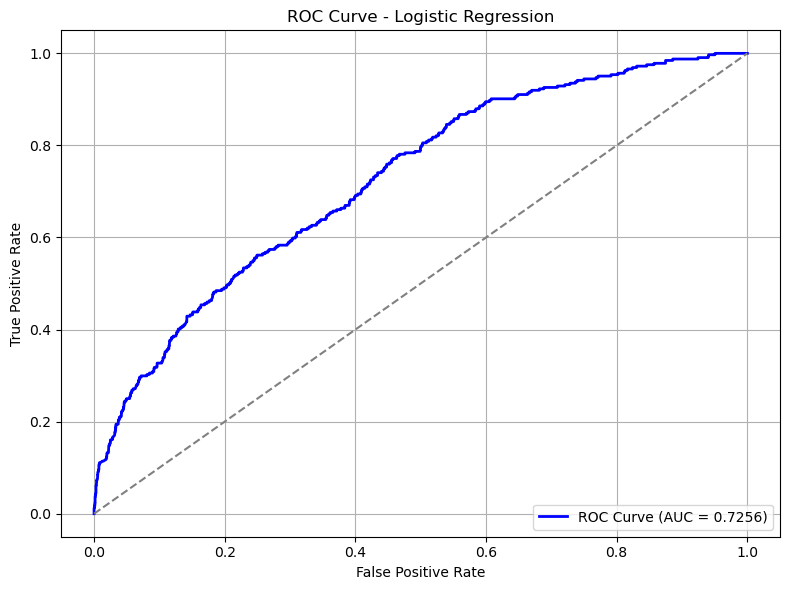

In [166]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# Compute FPR, TPR, and thresholds
fpr, tpr, thresholds = roc_curve(y_test, y_test_pred_pob)

# Compute AUC
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label=f"ROC Curve (AUC = {roc_auc:.4f})")
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')  # Diagonal line for random guess
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - Logistic Regression")
plt.legend(loc="lower right")
plt.grid(True)
plt.tight_layout()
plt.show()

This graph shows how this logistic regression model is performing after adjusting for multi-colinearity and accounting for the negative numeric variables. The graph shows the ROC-AUC curve and indicates that it's doing a decent job at differentiating between customers who transition and customers who do not transition.

In [ ]:
Logistic_coef = top_predictors['Feature']
lostistic_coef = set(Logistic_coef)
print(lostistic_coef.intersection(Remodelled_300_GAL_XGBoost_Top_Predictors))

In [40]:
small_df = results_df[results_df['Transition_Status_Label'] == 'small'].copy()
medium_df = results_df[results_df['Transition_Status_Label'] == 'medium'].copy()
high_df = results_df[results_df['Transition_Status_Label'] == 'high'].copy()
very_high_df = results_df[results_df['Transition_Status_Label'] == 'very high'].copy()

### Multiple Classes

I am curious if a logistic regression model will perform better if all the classes are labelled instead of a binary problem.

In [179]:
# Create copy of dataset
sccu_segmentation_04 = sccu.copy()
# Create new transition status variable with transition_status function
sccu_segmentation_04 = transition_status(sccu_segmentation_04,3,2,1,0)
# Use cleaning_data function to clean the dataset.
sccu_segmentation_04 = cleaning_data(sccu_segmentation_04)
# Drop multi-colinear columns from this dataset
sccu_segmentation_04= sccu_segmentation_04.drop(['DELIVERY_COST_2023','ANNUAL_VOLUME_2023','DELIVERY_COST_2023_CASES','ANNUAL_VOLUME_CASES_2023'],axis=1)


True


The above code basically utilizes the functions created previously to recreate the `Transition_Status` variable with all 4 scenarios, cleans the data and then finally drops the multi-colinear columns.

#### Dataset Proportions

In [180]:
counts = sccu_segmentation_04['Transition_Status'].value_counts()
percents = sccu_segmentation_04['Transition_Status'].value_counts(normalize=True) * 100
summary = pd.DataFrame({'Count': counts, 'Percentage': percents.round(2)})
print(summary)

                   Count  Percentage
Transition_Status                   
0                  21511       70.10
1                   6753       22.01
3                   1267        4.13
2                   1156        3.77


This graph shows the actual count and percentage of each group within the dataset. 3 represents __UP__, 2 represents __DOWN__, 1 represents __REMAINING_ABOVE__ and 0 represnts __REMAINING_BELOW__

#### Grid Search

In [181]:
# Step 1: Split the Dataset into Explanatory Dataset and Target
X,y = cross_validation(sccu_segmentation_04)

# Step 2: Drop NA rows
X = X.dropna()
y = y.loc[X.index]

# Step 3: Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, stratify=y, test_size=0.2, random_state=42
)

# Step 4: Define the pipeline
pipeline = ImbPipeline([
    ('smote', SMOTE(random_state=42)),
    ('scaler', StandardScaler()),
    ('logreg', LogisticRegression(multi_class='multinomial', solver='lbfgs', max_iter=1000))
])

# Step 5: Set up parameter grid
param_grid = {
    'logreg__C': [0.01, 0.1, 1, 10]
}

# Step 6: Run grid search
grid_search = GridSearchCV(
    estimator=pipeline,
    param_grid=param_grid,
    cv=5,
    scoring='roc_auc_ovr',
    n_jobs=-1,
    verbose=2
)

grid_search.fit(X_train, y_train)
# Get the best model directly
final_grid_model = grid_search.best_estimator_

# Step 7: Evaluate
print("Best Params:", grid_search.best_params_)
print("Train ROC-AUC:", grid_search.score(X_train, y_train))
print("Test ROC-AUC:", grid_search.score(X_test, y_test))

Fitting 5 folds for each of 4 candidates, totalling 20 fits


c:\Users\varun\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


Best Params: {'logreg__C': 10}
Train ROC-AUC: 0.879688584282134
Test ROC-AUC: 0.8752008504361009


#### ROC-AUC Score Single Class (UP)

The ROC-AUC Score is for all classes and shows how the model does at distinguishing the four classes from each other overall. In this case the model is doing a really great job at distinguishing between all the clases with a relatively high test score of .86 which is close to the train score of .92.

In [182]:
# Predict probabilities on test set
y_test_proba_class3 = final_grid_model.predict_proba(X_test)[:, 3]
y_train_proba_class3 = final_grid_model.predict_proba(X_train)[:,3]
# Binarize y_test: 1 if "Up" (3), 0 otherwise
y_test_binary = (y_test == 3).astype(int)
y_train_binary = (y_train == 3).astype(int)
# Compute ROC-AUC for class 3 vs all others
train_roc_auc_class3 = roc_auc_score(y_train_binary,y_train_proba_class3)
test_roc_auc_class3 = roc_auc_score(y_test_binary, y_test_proba_class3)

print("Train ROC-AUC for predicting 'Up'(class 3):",train_roc_auc_class3)
print("Test ROC-AUC for predicting 'Up' (class 3):", test_roc_auc_class3)

Train ROC-AUC for predicting 'Up'(class 3): 0.7145048773302929
Test ROC-AUC for predicting 'Up' (class 3): 0.7244260043454753


The above code is for showing how the model does at distinguishing class 3 (__UP__) from the rest of the classes. Based of the output, this model is performing very well at distinguishing Class 3 from the other classes wiht an AUC-ROC of .7244. This is however similar to than the ROC-AUC of .72 when the model was making predictions with the binary `Transition_Status` variable.

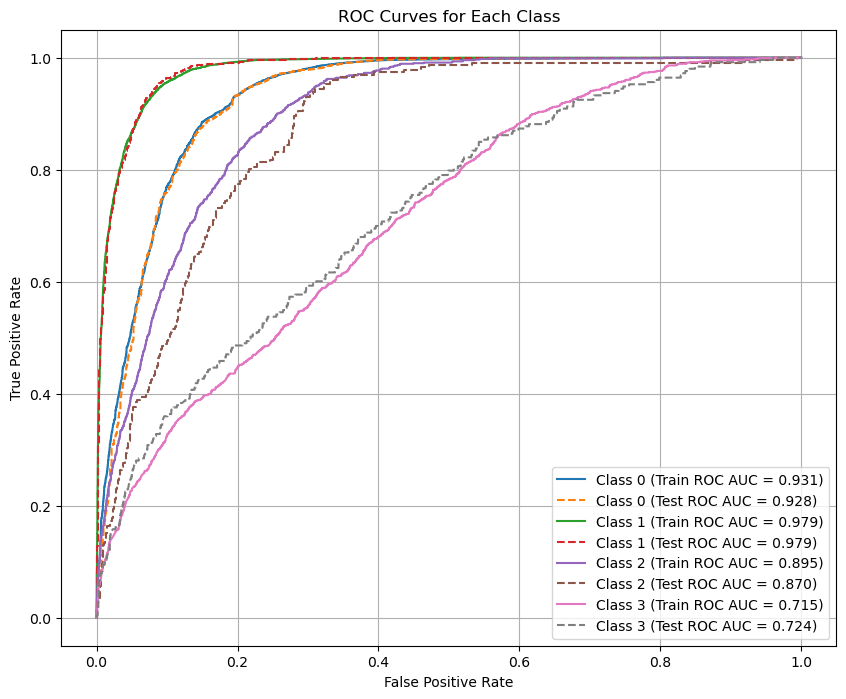

Class 0 - Train ROC-AUC: 0.9306, Test ROC-AUC: 0.9278
Class 1 - Train ROC-AUC: 0.9786, Test ROC-AUC: 0.9787
Class 2 - Train ROC-AUC: 0.8950, Test ROC-AUC: 0.8699
Class 3 - Train ROC-AUC: 0.7145, Test ROC-AUC: 0.7244


In [183]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, roc_auc_score

# Step 1: Get the predicted probabilities for all classes
y_train_pred_prob = final_grid_model.predict_proba(X_train)
y_test_pred_prob = final_grid_model.predict_proba(X_test)

# Step 2: Initialize plot for ROC curves
plt.figure(figsize=(10, 8))

# Step 3: Loop through each class and plot the ROC curve
for i in range(4):  # 4 classes (0, 1, 2, 3)
    # Get ROC curve values for train set
    fpr_train, tpr_train, _ = roc_curve(y_train == i, y_train_pred_prob[:, i])
    roc_auc_train = roc_auc_score(y_train == i, y_train_pred_prob[:, i])
    
    # Get ROC curve values for test set
    fpr_test, tpr_test, _ = roc_curve(y_test == i, y_test_pred_prob[:, i])
    roc_auc_test = roc_auc_score(y_test == i, y_test_pred_prob[:, i])
    
    # Plot train ROC curve
    plt.plot(fpr_train, tpr_train, label=f'Class {i} (Train ROC AUC = {roc_auc_train:.3f})')
    
    # Plot test ROC curve
    plt.plot(fpr_test, tpr_test, linestyle='--', label=f'Class {i} (Test ROC AUC = {roc_auc_test:.3f})')

# Step 4: Customize plot
#plt.plot([0, 1], [0, 1], linestyle='--', color='gray')  # Diagonal line (random classifier)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves for Each Class')
plt.legend(loc='lower right')
plt.grid(True)

# Step 5: Show plot
plt.show()

# Step 6: Optionally, print out ROC-AUC scores for each class
for i in range(4):
    train_roc_auc = roc_auc_score(y_train == i, y_train_pred_prob[:, i])
    test_roc_auc = roc_auc_score(y_test == i, y_test_pred_prob[:, i])
    print(f"Class {i} - Train ROC-AUC: {train_roc_auc:.4f}, Test ROC-AUC: {test_roc_auc:.4f}")

This plot shows the ROC-AUC scores for all the classes with the Train and Test Set scores shown. The model unfortunately does the least well on Class 3 since it has fewer observations in the dataset. It however is still a decent score and shows good generalizability

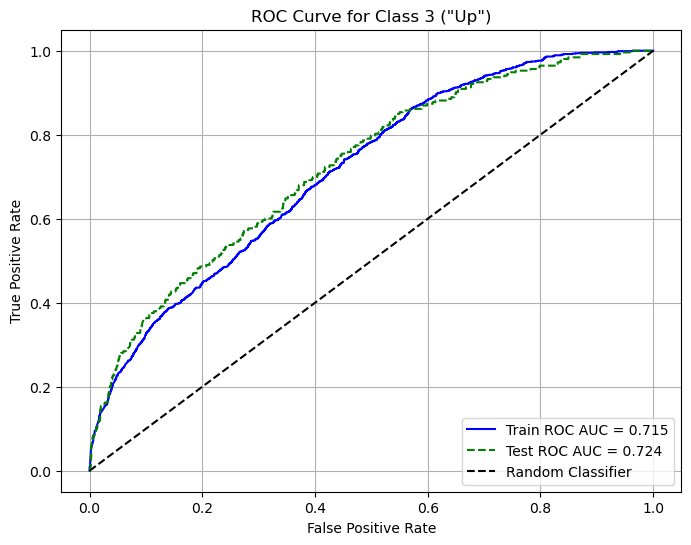

In [184]:
# Compute ROC curve and AUC for class 3 (train)
fpr_train, tpr_train, _ = roc_curve(y_train == 3, y_train_proba_class3)
roc_auc_train = roc_auc_score(y_train == 3, y_train_proba_class3)

# Compute ROC curve and AUC for class 3 (test)
fpr_test, tpr_test, _ = roc_curve(y_test == 3, y_test_proba_class3)
roc_auc_test = roc_auc_score(y_test == 3, y_test_proba_class3)

# Plot
plt.figure(figsize=(8, 6))
plt.plot(fpr_train, tpr_train, label=f'Train ROC AUC = {roc_auc_train:.3f}', color='blue')
plt.plot(fpr_test, tpr_test, label=f'Test ROC AUC = {roc_auc_test:.3f}', color='green', linestyle='--')
plt.plot([0, 1], [0, 1], 'k--', label='Random Classifier')

plt.title('ROC Curve for Class 3 ("Up")')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

This plot just shows the ROC-AUC score for the __UP__ class in the `Transition_Status` variable. As previoulsy mentioned, this is good performance and generalizability.

In [189]:
# Step 1: Make predictions on the entire dataset
y_pred = final_grid_model.predict(X)
# Step 2: Convert predictions to a pandas Series for easier analysis
y_pred_series = pd.Series(y_pred, name='Predicted_Class')

# Step 3: Calculate counts for each class
class_counts = y_pred_series.value_counts().sort_index()

# Step 4: Calculate percentages for each class
class_percentages = y_pred_series.value_counts(normalize=True).sort_index() * 100

# Step 5: Combine counts and percentages into a DataFrame
summary_df = pd.DataFrame({
    'Count': class_counts,
    'Percentage': class_percentages
})

# Step 6: Display the summary
print("Predictions of Classes\n", summary_df)

Predictions of Classes
                  Count  Percentage
Predicted_Class                   
0                20935   68.221071
1                 6624   21.585688
2                 1266    4.125525
3                 1862    6.067716


In [191]:
counts = sccu_segmentation_04['Transition_Status'].value_counts()
percents = sccu_segmentation_04['Transition_Status'].value_counts(normalize=True) * 100
summary = pd.DataFrame({'Count': counts, 'Percentage': percents.round(2)})
print("Actual Classes\n",summary)

Actual Classes
                    Count  Percentage
Transition_Status                   
0                  21511       70.10
1                   6753       22.01
3                   1267        4.13
2                   1156        3.77


The model is doing a fairly good job based on the above two code chunks at distinguishing between the various scnearios. For the first three scenarios, there is only a difference of 1-2%. For the final class, there is a difference of 2.30% which is very small.

In [195]:
# Extract feature names
feature_names = X.columns

# Get the coefficient matrix and class labels
coefs = final_grid_model.named_steps['logreg'].coef_
classes = final_grid_model.named_steps['logreg'].classes_

# Loop through each class and print top 10 coefficients
for idx, cls in enumerate(classes):
    coef_series = pd.Series(coefs[idx], index=feature_names)
    top_10 = coef_series.abs().sort_values(ascending=False).head(10)
    
    print(f"\n Top 10 important features for class {cls} vs base class:")
    print(coef_series.loc[top_10.index])


 Top 10 important features for class 0 vs base class:
ANNUAL_VOLUME_GALLON_2023                -19.765335
DELIVERY_COST_2023_GALLON                  5.372734
TRADE_CHANNEL_FAST CASUAL DINING          -3.531826
AVG_ORDER_VOLUME_2023                     -3.138971
COLD_DRINK_CHANNEL_BULK TRADE             -1.924621
SUB_TRADE_CHANNEL_OTHER GENERAL RETAIL    -1.779079
SUB_TRADE_CHANNEL_FSR - MISC              -1.616500
TRADE_CHANNEL_COMPREHENSIVE DINING        -1.616500
TRANS_COUNT_2023                          -1.504288
SUB_TRADE_CHANNEL_HOME & HARDWARE         -1.502419
dtype: float64

 Top 10 important features for class 1 vs base class:
ANNUAL_VOLUME_GALLON_2023                     10.857891
AVG_ORDER_VOLUME_2023                          3.364850
DELIVERY_COST_2023_GALLON                     -2.574848
TRANS_COUNT_2023                               2.297158
TRADE_CHANNEL_FAST CASUAL DINING               0.701193
TRADE_CHANNEL_GENERAL                          0.668847
SUB_TRADE_CHANNEL_O

The logistic regresion model's coefficients for the muli-class scenario are relatively similar to the binary scenario logistic regression model's coefficients. `AVG_ORDER_VOLUME_2023` is still one of the top predictors but it's negative. Since multi-colinearity has been addressed while this model was being trained, this means that negative signs are due to the `Transition_Status` variable. The model is still useful, however volume coefficents must be ignored.